# YOLO, YOLO PX, YOLO PX II method analysis and final errors for DS-IB
- Notebook of predictions, labelling and training is performed in the other one

In [ ]:
NOTEBOOK_CONFIG = {
    "label_mode": True,
    "train_mode": True,
    "IMG_LENGTH": 0.377,
    "IMG_WIDTH": 0.143,
    "IMG_XDIM": 143,
    "IMG_YDIM": 377,
    "labels_type": "Labelsv0_detect",
    "task": "detect",
    "model_name": "YOLOv0_E2_detect",
}

In [ ]:
# Folders
# Location of images
images_folder = f"docs/Data/Images/"
# Locations of yolo's datasets
yolo_folder = f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/"
# Location of labels
labels_folder = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/"
# Location of trained models
model_folder = f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/"

In [ ]:
# Path for sample image
n_image = 109
image_path = f"docs/Data/Images/gaussian_{n_image}.png"
label_path = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [24]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [26]:
import os
import pandas as pd
import numpy as np

from datetime import datetime
import scipy.io

from matplotlib import pyplot as plt
from adjustText import adjust_text

In [31]:
from ultralytics import YOLO
import cv2
from PIL import Image

# Load modules

In [ ]:
# Training runs (best)
bst_run = {
    "YOLOv0_detect": "2023-07-26_18-50-24",
    "YOLOv0_E2_detect": "2023-08-21_09-27-11",
    "YOLOv0_E3_detect": "2023-08-21_10-25-30",
    "YOLOv0_E4_detect": "2023-08-21_14-37-58",
    "YOLOv0_E12_detect": "2023-08-21_13-57-46",
    "YOLOv0_T80kenji_detect": "2023-09-04_11-19-43",
}

In [ ]:
# Load custom model
base_path = "docs/Models"
model_path = os.path.join(NOTEBOOK_CONFIG['model_name'], 
                          "runs", 
                          str(bst_run[NOTEBOOK_CONFIG['model_name']]), 
                          NOTEBOOK_CONFIG['task'])

model = YOLO(f"{base_path}/{model_path}/train/weights/best.pt")

In [ ]:
from helpers.gaussian_generator import generate_grid
from helpers.auxiliary_functions import parameters_extract, checkpoint_error
from helpers.aux_plotter import (
    plot_boxes,
    plot_boxes_gmm,
    gaussians_labelled,
    plot_grayscale,
    plot_box_labels,
)
from pipelines.pipelines import (
    ppl_fit_gaussians,
    ppl_error_estimation,
    ppl_yolo_predict_gaussians,
    ppl_yolo_px_predict_gaussians,
    ppl_ensemble_predict_gaussians,
)
from helpers.error_estimation import compute_error_per_gaussian

# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [35]:
# Load 400 gaussians
mat = scipy.io.loadmat("docs/Data/db_80beam.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [36]:
# Generate GRID
x, y = generate_grid(
    (0, NOTEBOOK_CONFIG["IMG_WIDTH"]),
    (0, NOTEBOOK_CONFIG["IMG_LENGTH"]),
    NOTEBOOK_CONFIG["IMG_XDIM"],
    NOTEBOOK_CONFIG["IMG_YDIM"],
)

# [ESTIMATION PART II]
- Images: 200 - 400
- Amplitudes: All amplitudes are higher around 2E6 (350%)
- x center: It has some Gaussians deslocated to left and others to right around 0.004 in x direction
- y center: Coincides with beta ys
- dispersion x : Higher dispersion in x direction around 0.006 (60%)
- dispersion y : Higher dispersion in y direction around 0.003 (60%)

## [ESTIMATION] Pipeline ppl_Yolo

### Predict with custom model - YOLO

In [44]:
os.listdir("docs/Models")

['YOLOv0_detect',
 'YOLOv0_E2_detect',
 'YOLOv0_E3_detect',
 'YOLOv0_E12_detect',
 'YOLOv0_E4_detect',
 'Archive',
 'YOLOv0_E1_detect',
 'YOLOv0_T80kenji_detect']

In [45]:
os.listdir("docs/Models/YOLOv0_detect/datasets/test/images/")

['gaussian_277.png',
 'gaussian_204.png',
 'gaussian_385.png',
 'gaussian_217.png',
 'gaussian_257.png',
 'gaussian_285.png',
 'gaussian_310.png',
 'gaussian_306.png',
 'gaussian_334.png',
 'gaussian_241.png',
 'gaussian_363.png',
 'gaussian_253.png',
 'gaussian_348.png',
 'gaussian_349.png',
 'gaussian_203.png',
 'gaussian_274.png',
 'gaussian_292.png',
 'gaussian_395.png',
 'gaussian_364.png',
 'gaussian_239.png']

In [46]:
# Wrap sizes and ranges
image_ranges = [(0, NOTEBOOK_CONFIG["IMG_WIDTH"]), (0, NOTEBOOK_CONFIG["IMG_LENGTH"])]
image_size = [NOTEBOOK_CONFIG["IMG_XDIM"], NOTEBOOK_CONFIG["IMG_YDIM"]]

In [47]:
# Make the prediction
img = cv2.imread(image_path)
results = model.predict(img)

# class 0 boxes
tensor_boxes = results[0].boxes.xyxy

# Centers
means_yolo = [
    (float(x), float(y))
    for x, y in zip(
        results[0].boxes.xywhn[:, 0] * image_size[0],
        results[0].boxes.xywhn[:, 1] * image_size[1],
    )
]


0: 640x256 79 gaussians, 835.5ms
Speed: 23.6ms preprocess, 835.5ms inference, 41.8ms postprocess per image at shape (1, 3, 640, 256)


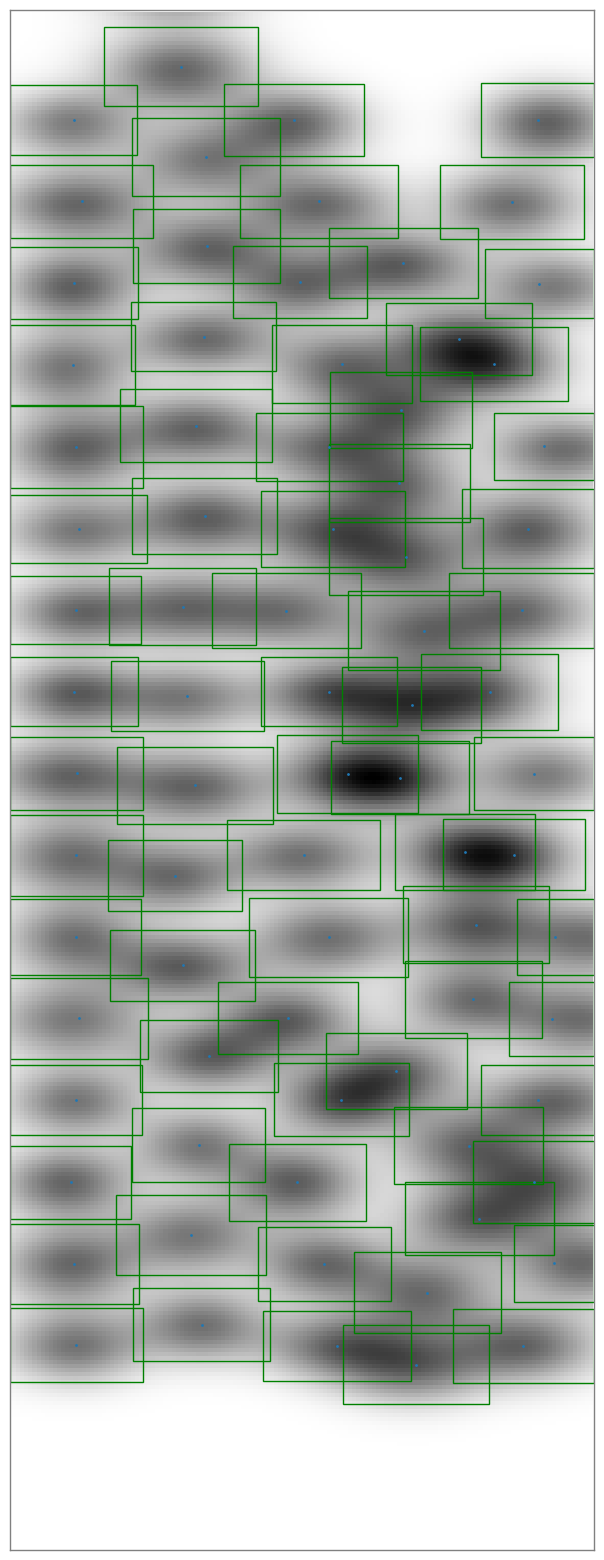

In [77]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, ax = plt.subplots(1, figsize=(15, 20))

# Display the image and plot predicted centers
ax.imshow(im)
plot_boxes(tensor_boxes, ax, edge_color="g")
ax.set_ylim(ax.get_ylim()[::-1])
ax.scatter(np.array(means_yolo)[:, 0], np.array(means_yolo)[:, 1], s=1)
# axs[2].axis('off')
ax.set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
ax.set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])

ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor("gray")
    spine.set_linewidth(1)

plt.show()

In [ ]:
# Estimate Gaussian - Final prediction
image = [x, y, mat["F_data"][:, :, n_image]]
(means, covariances, angles, amplitudes) = ppl_fit_gaussians(
    image,
    means_init="laplace",
    peak_method="laplace",
    em_iterations=1000,
    covariance_gaussians_type="diag",
    n_gaussians=None,
    image_ranges=image_ranges,
    image_size=image_size,
    fig_size=(10, 8),
    plot=True,
    plot_points=True,
)

Number of indentifiable Gaussians (center in the image): 79


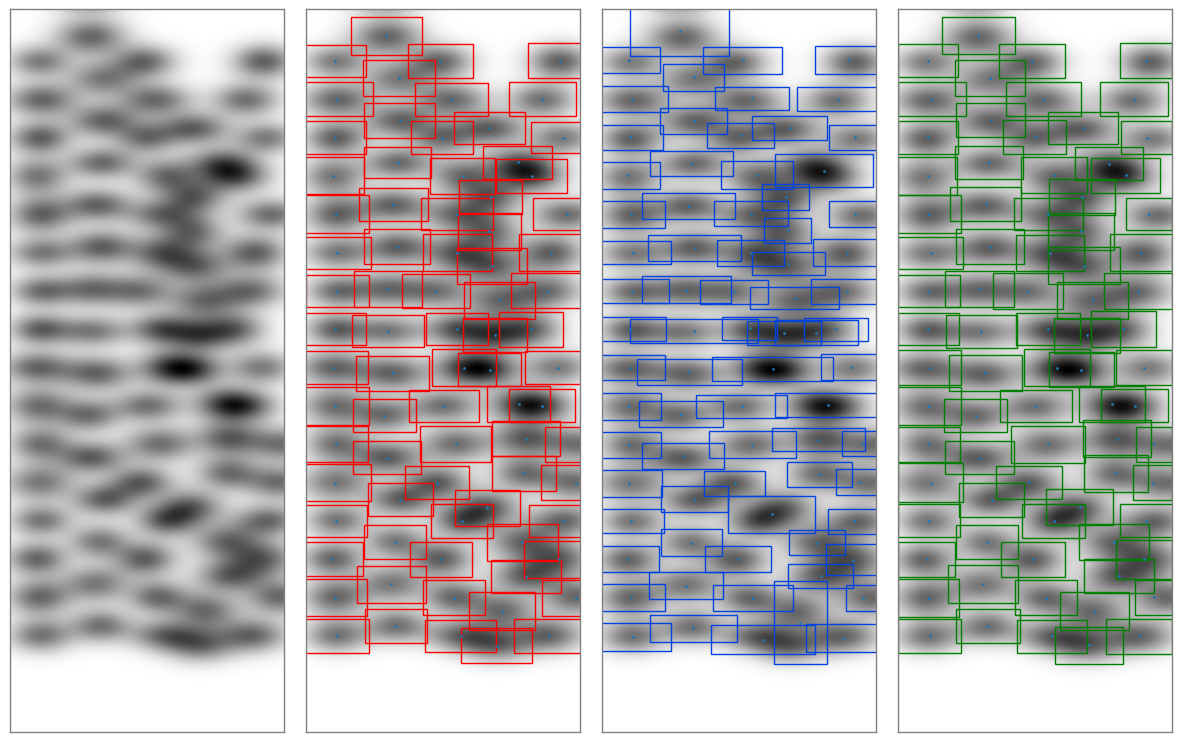

In [48]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 4, figsize=(15, 20))

# Display the image and plot predicted centers GMM
axs[2].imshow(im)
plot_boxes_gmm(
    means=means, covariances=covariances, ax=axs[2], beta=3, edge_color="#0343DF"
)
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:, 0] * 1000, means[:, 1] * 1000, s=1)
# axs[3].axis('off')
axs[2].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[2].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])


# Display the image and plot predicted centers
axs[3].imshow(im)
plot_boxes(tensor_boxes, axs[3], edge_color="g")
axs[3].set_ylim(axs[2].get_ylim()[::-1])
axs[3].scatter(np.array(means_yolo)[:, 0], np.array(means_yolo)[:, 1], s=1)
# axs[2].axis('off')
axs[3].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[3].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])

# axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(
    image_path,
    label_path,
    axs[1],
    task=NOTEBOOK_CONFIG["task"],
    colorbar=False,
    plot_centers=True,
)
# axs[1].axis('off')
axs[1].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[1].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
# axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar=False, ax=axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[0].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])


for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

    ax.set_xticks([])
    ax.set_yticks([])
    # Change the color of the axis spines (borders)
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")
        spine.set_linewidth(1)

plt.subplots_adjust(wspace=0.08)
plt.show()

### Error evaluation

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
# Iterate all images - GMM method
results = {'Image' : [],
           'Number identified - YOLO' : [],
           'Number identifiable - YOLO' : [],
           'Percentage - YOLO' : [],
           'RMSE_cx - YOLO' : [],
           'RMSE_cy - YOLO' : [],
           'RMSE_c - YOLO' : [],
           'RMSE_sigmax - YOLO' : [],
           'RMSE_sigmay - YOLO' : [],
           'RMSE_sigma - YOLO' : [],
           'MaxE_sigmax - YOLO': [],
           'MaxE_sigmay - YOLO': [],
           'MaxE_sigma - YOLO': [],
           'RMSE_amplitude - YOLO': [],
           'RMSEPixel - YOLO': []}

for n_image in eval_images:
  eval_gaussian = ppl_error_estimation(n_image,
                                       mat,
                                       estimation_method = "YOLO",
                                       image_path = "Data/Images/"
                                       yolo_model = model,
                                       covariance_gaussians_types = "diag",
                                       return_percentage = True)
  # Append values in the dictionary
  for key in results.keys():
      if key in eval_gaussian:
          results[key] += eval_gaussian[key]


0: 640x256 81 gaussians, 553.1ms
Speed: 2.0ms preprocess, 553.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015585           0]
  [          0   0.0090219]]]
covariances true [[[   0.015205           0]
  [          0   0.0088653]]]
[  0.0088653    0.008092   0.0085297   0.0086731   0.0086458   0.0087261   0.0086288    0.008905   0.0090928   0.0080636   0.0086718   0.0091638   0.0080114   0.0087597   0.0086324   0.0083234   0.0087708   0.0086578   0.0090291     0.00829   0.0080466   0.0084427   0.0079471   0.0092807   0.0092982   0.0080415
   0.0091111   0.0088719   0.0084457   0.0083007   0.0086343   0.0086465   0.0079348   0.0081754   0.0092826   0.0082577   0.0087105   0.0079136   0.0084938   0.0087846   0.0083184   0.0084655   0.0092379   0.0079402   0.0079663   0.0078271   0.0092413   0.0092086   0.0088036   0.0090013   0.0087886   0.0081482
   0.0086861   0.0080236   0.0090704   0.0088825   0.0089634   0.0086174   0.0081102     0.00923   0.0090388   0.0087296   0.0079061   0.0079837   0.0082576   0.0090007   0.0077923   0.0084662   0.0086869   0.0079816   0.0087329 


0: 640x256 80 gaussians, 410.4ms
Speed: 2.0ms preprocess, 410.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01528           0]
  [          0   0.0083578]]]
covariances true [[[   0.015266           0]
  [          0   0.0083557]]]
[  0.0083557   0.0078309   0.0090974   0.0086405   0.0089947   0.0081714   0.0088093   0.0086319   0.0086602   0.0084805   0.0081623   0.0088895   0.0089673    0.009305   0.0080211   0.0089316   0.0080425   0.0090988   0.0093046   0.0087324   0.0079959   0.0080314   0.0083747    0.007862   0.0087074   0.0085817
   0.0085211   0.0085417   0.0092592   0.0085813   0.0091434   0.0087796   0.0082186   0.0086322   0.0078023   0.0078106   0.0086563   0.0081741   0.0086239     0.00789   0.0083659    0.008516   0.0085875   0.0088656   0.0078953   0.0078844   0.0087601   0.0087634   0.0080779   0.0087077    0.007871   0.0080017
   0.0092163    0.008987   0.0081565   0.0083219   0.0085416   0.0090771   0.0082864   0.0085794   0.0090092   0.0079506   0.0085312   0.0089851   0.0093066   0.0086864   0.0090445    0.009177   0.0090966    0.007975   0.0078367 


0: 640x256 79 gaussians, 240.1ms
Speed: 1.9ms preprocess, 240.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015075           0]
  [          0   0.0082626]]]
covariances true [[[   0.015375           0]
  [          0   0.0081417]]]
[  0.0081417   0.0085719   0.0084101   0.0089638   0.0080752   0.0089468   0.0085706   0.0080281   0.0082787   0.0080241   0.0087407   0.0081897   0.0085227   0.0088095    0.008427   0.0082568   0.0083469   0.0086937    0.008594   0.0088114   0.0081366   0.0090927   0.0084632   0.0091254   0.0090201    0.008802
   0.0079019   0.0080747   0.0082534   0.0088663    0.007784   0.0081426    0.008841   0.0093174   0.0086612   0.0085581   0.0079892   0.0087667    0.008744   0.0078634   0.0081935   0.0082666   0.0083622   0.0079421   0.0087203   0.0081256   0.0091847   0.0089593   0.0091786   0.0086978   0.0082731   0.0086265
   0.0087486   0.0084448   0.0090885   0.0083899   0.0081065    0.008858   0.0092092   0.0089296   0.0078271    0.008635   0.0078466    0.009138   0.0084847   0.0082821   0.0082815   0.0085678   0.0092319   0.0088915   0.0082872 


0: 640x256 79 gaussians, 227.5ms
Speed: 2.8ms preprocess, 227.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016489           0]
  [          0   0.0088559]]]
covariances true [[[   0.016586           0]
  [          0   0.0088953]]]
[  0.0088953   0.0086979   0.0088241   0.0092608   0.0090789   0.0087953    0.008282   0.0081848   0.0082518   0.0079898   0.0087861   0.0092645    0.008142   0.0090701   0.0089773   0.0090461   0.0081999   0.0079772   0.0083364    0.008939   0.0091941   0.0079321   0.0086228   0.0084139   0.0093026   0.0081251
   0.0078626   0.0086077   0.0083875   0.0082658   0.0078298   0.0083071   0.0092665   0.0088527   0.0083769   0.0092527   0.0087029   0.0078129   0.0080032   0.0093032   0.0089664   0.0089727   0.0084592   0.0082661   0.0079981   0.0086026   0.0084179   0.0086512   0.0078318   0.0082504   0.0088876   0.0083318
    0.008884   0.0088506   0.0080087   0.0091336    0.008903   0.0078935   0.0091654   0.0082491   0.0085284   0.0089558    0.008668   0.0078603   0.0086175   0.0083432    0.009301   0.0078466   0.0086579   0.0078078    0.008002 


0: 640x256 79 gaussians, 234.4ms
Speed: 1.9ms preprocess, 234.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016688           0]
  [          0   0.0092295]]]
covariances true [[[   0.017878           0]
  [          0   0.0092539]]]
[  0.0092539    0.009306    0.009063   0.0092858     0.00914   0.0088942   0.0085318   0.0077847   0.0092036   0.0085757   0.0085996   0.0092721   0.0081175   0.0083506    0.008391   0.0078672   0.0089105   0.0083793    0.008474   0.0092137   0.0083194    0.008774   0.0081791   0.0078244   0.0083105   0.0090672
   0.0086694   0.0078432   0.0084366   0.0083264   0.0080525   0.0082392   0.0078313   0.0085857   0.0083886   0.0078518   0.0080897   0.0080987   0.0089104   0.0082117   0.0083073   0.0089669     0.00858    0.009332   0.0079973   0.0084151   0.0093032   0.0087061   0.0082787   0.0082366   0.0085477   0.0083734
   0.0086283   0.0092378   0.0092478   0.0081052   0.0081862   0.0079697   0.0090086   0.0082826   0.0091909   0.0093144     0.00868   0.0079191   0.0084816   0.0079464   0.0081869   0.0088607   0.0088776   0.0082231   0.0082462 


0: 640x256 80 gaussians, 227.7ms
Speed: 1.9ms preprocess, 227.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015735           0]
  [          0   0.0090641]]]
covariances true [[[   0.015869           0]
  [          0   0.0090337]]]
[  0.0090337   0.0084164   0.0088377   0.0086056   0.0091292   0.0082159   0.0089073   0.0087389   0.0092123   0.0091318   0.0079301   0.0083068   0.0079738   0.0091888   0.0089292   0.0087207   0.0085655   0.0078989   0.0086533   0.0093334   0.0090563   0.0078153   0.0086785   0.0090761   0.0080225   0.0081819
   0.0085898   0.0082689   0.0084123   0.0093303   0.0077926    0.007946   0.0090967   0.0078459   0.0087516   0.0079459   0.0090687   0.0079062   0.0090629   0.0092904   0.0089457    0.008003   0.0089579   0.0092523   0.0077956   0.0089431   0.0090394   0.0082176   0.0090063   0.0080723   0.0089395   0.0085258
   0.0091414   0.0090023   0.0087964   0.0083474   0.0091852   0.0086517   0.0091156   0.0084139   0.0079736   0.0078091   0.0092156   0.0082014   0.0091557   0.0089349   0.0080377   0.0080204   0.0086409   0.0080088    0.009109 


0: 640x256 80 gaussians, 237.1ms
Speed: 2.1ms preprocess, 237.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014026           0]
  [          0    0.008821]]]
covariances true [[[   0.014993           0]
  [          0   0.0087786]]]
[  0.0087786   0.0086977   0.0093247   0.0078836   0.0088717   0.0089654   0.0092385   0.0084034   0.0081402   0.0091553   0.0077921   0.0079258   0.0091721   0.0084426   0.0081484   0.0078563   0.0078148   0.0079242   0.0088833    0.009183   0.0091397   0.0089845   0.0082538   0.0081566   0.0092258   0.0091789
   0.0085734   0.0086317   0.0090068    0.008373   0.0081598   0.0088178   0.0086103   0.0087044   0.0080201   0.0089468   0.0086186   0.0084579   0.0080236   0.0084574    0.009207   0.0083003   0.0080404    0.008755   0.0088871   0.0078546   0.0083207   0.0093222   0.0081434   0.0092817   0.0085759   0.0079157
   0.0087721   0.0083097   0.0086353   0.0089144    0.008374   0.0087584   0.0081243   0.0083155   0.0081997    0.008109   0.0085558   0.0085532    0.008774   0.0081252   0.0090048   0.0091031   0.0079329   0.0086423   0.0085618 


0: 640x256 79 gaussians, 237.4ms
Speed: 1.5ms preprocess, 237.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016145           0]
  [          0   0.0088145]]]
covariances true [[[   0.016137           0]
  [          0   0.0089511]]]
[  0.0089511   0.0087966   0.0083591   0.0084777    0.009226   0.0085694   0.0084912   0.0089997   0.0088216   0.0089916   0.0081601   0.0085322   0.0091621   0.0091234   0.0092801   0.0087918   0.0086798    0.008055   0.0086422   0.0086131   0.0090966   0.0087559   0.0077979   0.0084312    0.009298   0.0091762
   0.0087996   0.0078409   0.0092186   0.0084609   0.0080598   0.0079046   0.0080177   0.0083586    0.007982   0.0079656   0.0086667   0.0087367   0.0088788   0.0084191   0.0081921   0.0078394   0.0081107   0.0082817   0.0084324   0.0085202   0.0083244   0.0081449   0.0086943   0.0088413   0.0084949   0.0079502
   0.0079045   0.0091157   0.0090776   0.0080187   0.0081023   0.0083645   0.0089863   0.0080336   0.0082936   0.0090991   0.0079025   0.0078983    0.009234   0.0086255   0.0082454    0.007844   0.0085204   0.0086955   0.0084502 


0: 640x256 79 gaussians, 230.8ms
Speed: 3.1ms preprocess, 230.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015265           0]
  [          0   0.0090555]]]
covariances true [[[    0.01559           0]
  [          0   0.0088846]]]
[  0.0088846   0.0091857   0.0086838   0.0093177   0.0080151   0.0082113   0.0091493   0.0091195   0.0085967    0.007906   0.0090798   0.0087549   0.0083339   0.0092119    0.008348    0.008062   0.0089891   0.0080636   0.0083628    0.009132   0.0084611   0.0084627   0.0087333   0.0083246   0.0080471   0.0083366
   0.0083416   0.0088423   0.0091578   0.0091515   0.0085036   0.0079507   0.0080914   0.0082138   0.0083855   0.0082023   0.0087184   0.0080885   0.0085011   0.0081155   0.0090192   0.0082167   0.0087595    0.008545   0.0079659   0.0082422   0.0086208   0.0088673   0.0082927   0.0079492    0.007852   0.0092166
   0.0089493   0.0084203   0.0085996   0.0078536   0.0083654   0.0087266   0.0089691   0.0092463   0.0080153    0.007908   0.0082931   0.0081072   0.0088154   0.0086241   0.0086752   0.0089676   0.0078627   0.0083312   0.0081062 


0: 640x256 80 gaussians, 243.3ms
Speed: 2.3ms preprocess, 243.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016231           0]
  [          0   0.0087085]]]
covariances true [[[   0.016025           0]
  [          0   0.0086327]]]
[  0.0086327   0.0091911   0.0092588   0.0086664   0.0090212   0.0086449   0.0084144   0.0091515   0.0080398    0.008337    0.008531   0.0084213   0.0079435   0.0079575    0.009056   0.0091225   0.0086477   0.0092375   0.0086085   0.0087869    0.008549   0.0087105   0.0092965   0.0078143   0.0082248   0.0079677
    0.007838   0.0088343   0.0084913   0.0086177   0.0086312   0.0078996   0.0085429   0.0086769   0.0086572   0.0089022   0.0079377   0.0083191   0.0086296   0.0080846   0.0086714   0.0085407   0.0082935    0.008923   0.0089142   0.0092769   0.0079805   0.0078334   0.0090117    0.008046   0.0083027   0.0093093
   0.0088342   0.0084224     0.00906   0.0089079   0.0081969    0.007871   0.0081911   0.0086646   0.0087098   0.0086826   0.0090577   0.0085462    0.008144   0.0091145   0.0079682    0.009092   0.0088653   0.0089567   0.0086614 


0: 640x256 79 gaussians, 243.5ms
Speed: 1.9ms preprocess, 243.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015735           0]
  [          0   0.0082531]]]
covariances true [[[   0.015811           0]
  [          0   0.0082725]]]
[  0.0082725   0.0092517   0.0090651   0.0088413   0.0084428   0.0083009   0.0091322    0.008236   0.0081495   0.0087644   0.0085669   0.0093151   0.0082595    0.008567   0.0079269   0.0089684   0.0082644   0.0083899   0.0078322   0.0078821   0.0081279   0.0088304    0.007977   0.0078689     0.00839   0.0084522
   0.0092853    0.009027   0.0080234   0.0090128   0.0091332   0.0086203   0.0093343   0.0081458    0.008142   0.0086643   0.0086476   0.0082931   0.0079806   0.0089343   0.0081591    0.007958   0.0085598   0.0086884    0.008393   0.0082101   0.0090708   0.0086872   0.0091203    0.008673   0.0081985    0.007963
   0.0088169   0.0079587   0.0080637   0.0078863   0.0087091   0.0086319   0.0089765    0.008509    0.007836   0.0088357   0.0093157   0.0078742   0.0083681   0.0082993   0.0093363   0.0091816   0.0087489   0.0081328   0.0090094 


0: 640x256 80 gaussians, 394.1ms
Speed: 1.8ms preprocess, 394.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016375           0]
  [          0    0.009028]]]
covariances true [[[   0.016695           0]
  [          0   0.0091382]]]
[  0.0091382   0.0092253   0.0087515    0.008307   0.0087843   0.0081435   0.0084166   0.0084424   0.0084232   0.0093077   0.0090344   0.0086586   0.0087609   0.0082116   0.0080599   0.0088387   0.0089058   0.0084094   0.0086609   0.0080499    0.009058   0.0090911   0.0093129   0.0086227   0.0079596   0.0093184
   0.0082837   0.0089076   0.0080109   0.0087456   0.0088009   0.0082622   0.0081287   0.0083737   0.0087733   0.0083426    0.009048    0.009112   0.0090635   0.0085706   0.0084829   0.0079908   0.0088591   0.0092341    0.008394   0.0090567   0.0087158   0.0079799   0.0079424   0.0085268   0.0080583   0.0087712
    0.008325   0.0084917   0.0091388   0.0082039   0.0087508   0.0080384    0.009208   0.0083254   0.0089117   0.0092789   0.0092655   0.0080595   0.0090261   0.0087078   0.0079006   0.0092834   0.0092878   0.0089449   0.0091361 


0: 640x256 79 gaussians, 388.2ms
Speed: 1.9ms preprocess, 388.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01613           0]
  [          0   0.0091919]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]
[  0.0091864   0.0081998   0.0088357   0.0092073   0.0081333   0.0091619   0.0089733   0.0084563   0.0092489   0.0088709   0.0089957   0.0084046   0.0077993   0.0080284   0.0081511   0.0093183   0.0086642   0.0085482   0.0078285   0.0086629   0.0079277   0.0093345   0.0087215   0.0088081   0.0078815   0.0086545
   0.0078728   0.0080544   0.0090825   0.0081713   0.0092532   0.0078075   0.0078844   0.0083276    0.008379    0.009196   0.0092212   0.0090404   0.0089863   0.0088531   0.0081277   0.0087144    0.008182   0.0082907   0.0088356   0.0079705   0.0090879   0.0084432   0.0087237   0.0085656   0.0088676   0.0084929
   0.0081442   0.0083711   0.0084899   0.0085772   0.0081427   0.0084083   0.0089676   0.0081449   0.0084542   0.0087708   0.0086527   0.0082124   0.0082048   0.0082374   0.0092149   0.0088149   0.0087121   0.0082989   0.0079993 


0: 640x256 79 gaussians, 404.0ms
Speed: 1.8ms preprocess, 404.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015491           0]
  [          0   0.0091317]]]
covariances true [[[   0.016137           0]
  [          0   0.0089708]]]
[  0.0089708   0.0091479   0.0082811   0.0085069   0.0091732   0.0078756   0.0084848   0.0091656   0.0080159   0.0081275   0.0088396   0.0087143   0.0083284   0.0079984   0.0080454   0.0089306   0.0091742   0.0085688   0.0085467   0.0080184   0.0079641   0.0081106   0.0086775   0.0080797   0.0090337   0.0091384
   0.0090151   0.0089774   0.0087401   0.0090971   0.0081753   0.0085301   0.0078904    0.008726   0.0078401   0.0079013     0.00779   0.0079963   0.0079115   0.0090902   0.0083783    0.008067   0.0089255   0.0080019      0.0092   0.0078618   0.0087816   0.0087216   0.0079944   0.0084934   0.0082326    0.008675
   0.0089306    0.008024   0.0088625   0.0085025   0.0091851   0.0084036   0.0090627   0.0093238   0.0079455   0.0077943   0.0087367   0.0081914   0.0086179   0.0078365   0.0085996   0.0085055   0.0084712   0.0080296   0.0082884 


0: 640x256 79 gaussians, 404.6ms
Speed: 6.0ms preprocess, 404.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015319           0]
  [          0   0.0093809]]]
covariances true [[[   0.016054           0]
  [          0   0.0092144]]]
[  0.0092144   0.0090371   0.0085779   0.0085891   0.0079321   0.0078797   0.0082158   0.0084329   0.0081716   0.0085574   0.0082386   0.0091431   0.0078799   0.0085829    0.008055   0.0092294   0.0086059   0.0078759   0.0090465   0.0078506   0.0084904   0.0082991   0.0082495   0.0084521   0.0084945   0.0078056
   0.0089321   0.0092171   0.0081705   0.0088895   0.0082391   0.0078217    0.007883   0.0082798   0.0086185   0.0083617     0.00929   0.0080666   0.0080803   0.0090104    0.008531   0.0087655   0.0086644   0.0080563   0.0085026   0.0082387   0.0092288   0.0080021    0.007823   0.0084243   0.0079624   0.0090953
   0.0078837   0.0086179   0.0082249   0.0087009    0.009308   0.0085203   0.0089442   0.0078843   0.0088309   0.0090822   0.0084588   0.0078817   0.0089813   0.0090251   0.0088804   0.0079145   0.0082837   0.0084961   0.0081266 


0: 640x256 79 gaussians, 376.3ms
Speed: 1.7ms preprocess, 376.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016238           0]
  [          0   0.0091766]]]
covariances true [[[   0.017192           0]
  [          0   0.0090986]]]
[  0.0090986   0.0086068   0.0086193   0.0090259   0.0085644   0.0092093   0.0082563   0.0092712   0.0093299   0.0089284    0.009112   0.0085521   0.0083249   0.0081311   0.0079852   0.0078976   0.0088954   0.0082229   0.0081059   0.0082441   0.0082057   0.0089852   0.0080453   0.0086871   0.0084081   0.0084613
   0.0082581   0.0079014     0.00864   0.0082824   0.0090417   0.0083144   0.0080963   0.0079987   0.0080175   0.0081437   0.0078196   0.0081219    0.008194   0.0090821   0.0083003   0.0082332   0.0078224   0.0088034    0.009037   0.0080791   0.0088068   0.0082104   0.0085539    0.008439   0.0092372   0.0088329
   0.0083592   0.0082417   0.0078817   0.0086272   0.0079746   0.0077989   0.0085693   0.0084438   0.0092752   0.0083557   0.0085895   0.0079482   0.0084555   0.0081826   0.0090604   0.0081691   0.0083219   0.0083497   0.0085297 


0: 640x256 79 gaussians, 246.2ms
Speed: 1.7ms preprocess, 246.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016334           0]
  [          0   0.0089378]]]
covariances true [[[   0.016488           0]
  [          0   0.0091941]]]
[  0.0091941   0.0084899   0.0091316   0.0088842    0.008535   0.0084282   0.0090079   0.0089813   0.0091241   0.0085317   0.0088481   0.0082897   0.0092548   0.0085868   0.0081515   0.0080888   0.0090677   0.0092026   0.0088991    0.009298   0.0084785   0.0080574     0.00822   0.0082907   0.0093285   0.0086879
   0.0083793   0.0078616   0.0086381   0.0083687   0.0089255   0.0085636   0.0083416   0.0082568   0.0093102   0.0082771   0.0081523   0.0084643   0.0086007   0.0080581   0.0078704   0.0078169   0.0080902   0.0089696   0.0091621   0.0085462   0.0086617    0.008281   0.0090143   0.0085914   0.0092735   0.0078341
   0.0086796   0.0082905   0.0091533   0.0090661   0.0090326    0.007903   0.0084423   0.0079473   0.0089735   0.0082582   0.0078431   0.0088786    0.008126    0.008469   0.0081487   0.0082526   0.0092709   0.0092022   0.0080389 


0: 640x256 79 gaussians, 226.3ms
Speed: 2.6ms preprocess, 226.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015604           0]
  [          0   0.0094738]]]
covariances true [[[   0.016279           0]
  [          0   0.0092726]]]
[  0.0092726   0.0085711   0.0089198   0.0090954   0.0093327     0.00857   0.0079059   0.0085042    0.007944   0.0082528   0.0090259   0.0088078    0.009104   0.0086838    0.007898   0.0085396   0.0080708   0.0092164   0.0093009   0.0089268   0.0087474   0.0079775   0.0088045   0.0089212   0.0091964   0.0090065
   0.0082623   0.0082743   0.0084179   0.0080239   0.0085604   0.0080365   0.0089214   0.0084395   0.0080413    0.007807   0.0084317   0.0089095   0.0081177   0.0083592   0.0086811   0.0080885   0.0078755   0.0092373   0.0091379   0.0080675     0.00809   0.0078496   0.0092387    0.007954   0.0082072   0.0079096
   0.0080317   0.0078614   0.0082246   0.0077914   0.0082992   0.0084618    0.008175   0.0091305   0.0089936   0.0078115   0.0092576   0.0087249   0.0078831   0.0081138   0.0083154   0.0088727   0.0078056   0.0084221   0.0077893 


0: 640x256 80 gaussians, 227.4ms
Speed: 1.9ms preprocess, 227.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016577           0]
  [          0   0.0091138]]]
covariances true [[[   0.016684           0]
  [          0   0.0091856]]]
[  0.0091856   0.0092198   0.0091566   0.0081512    0.009105   0.0078191   0.0089041   0.0082895   0.0085621   0.0091173   0.0089932   0.0091993   0.0085524   0.0092304   0.0087637   0.0088733   0.0089995   0.0086961   0.0087934   0.0081081   0.0082431   0.0083543   0.0087197   0.0084882   0.0080333   0.0081104
   0.0090688   0.0082703   0.0078806   0.0078243   0.0082358    0.009212   0.0078124   0.0078141   0.0084012   0.0081929   0.0087603   0.0082893   0.0087635   0.0078498   0.0086248   0.0087323   0.0079828    0.008699   0.0084762   0.0086388    0.007809   0.0082791   0.0086061   0.0082933   0.0080313    0.008149
   0.0082997   0.0091435   0.0083774   0.0091789   0.0083314   0.0092456   0.0086315   0.0079449   0.0085367   0.0079393   0.0088013   0.0092229   0.0089847   0.0088487   0.0078573   0.0082738   0.0078233   0.0085728   0.0082893 


0: 640x256 79 gaussians, 224.6ms
Speed: 1.8ms preprocess, 224.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014455           0]
  [          0   0.0079499]]]
covariances true [[[   0.015817           0]
  [          0   0.0080224]]]
[  0.0080224   0.0080609   0.0078471   0.0087371   0.0078245   0.0090711   0.0091293   0.0093023   0.0091218   0.0087015    0.009059   0.0084308   0.0092208   0.0083197    0.009084   0.0084207   0.0090273   0.0088102   0.0092063   0.0087561   0.0086196   0.0088785   0.0084273   0.0086529   0.0082293   0.0091828
   0.0091091    0.008023   0.0080142   0.0079348   0.0087715   0.0080905   0.0079375   0.0078741   0.0087182   0.0081605   0.0080227   0.0092304   0.0082637   0.0091554   0.0089153   0.0086825   0.0087617   0.0080001   0.0093059   0.0090095   0.0089922   0.0081695   0.0078576   0.0084848   0.0085994   0.0086922
   0.0087123   0.0085094   0.0078406   0.0089658   0.0081547   0.0084937   0.0081388   0.0084208    0.007857   0.0084514   0.0081328   0.0083018   0.0084829   0.0080502   0.0090897   0.0086076   0.0088699   0.0091126    0.008416 

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,294.80,59.84,395.00
Number identified - YOLO,79.40,0.60,81.00
Number identifiable - YOLO,79.00,0.00,79.00
Percentage - YOLO,100.51,0.76,102.53
RMSE_cx - YOLO,2.11,0.19,2.56
RMSE_cy - YOLO,0.07,0.01,0.10
RMSE_c - YOLO,2.11,0.19,2.56
RMSE_sigmax - YOLO,5.66,0.61,7.17
RMSE_sigmay - YOLO,1.71,0.50,2.61
RMSE_sigma - YOLO,5.93,0.66,7.53


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values("Image")

,Image,Number identified - YOLO,Number identifiable - YOLO,Percentage - YOLO,RMSE_cx - YOLO,RMSE_cy - YOLO,RMSE_c - YOLO,RMSE_sigmax - YOLO,RMSE_sigmay - YOLO,RMSE_sigma - YOLO,MaxE_sigmax - YOLO,MaxE_sigmay - YOLO,MaxE_sigma - YOLO,RMSE_amplitude - YOLO,RMSEPixel - YOLO
14,203,79,79,100.00,1.99,0.06,2.00,5.95,1.68,6.18,47.83,5.57,48.15,12.62,415887.64
1,204,80,79,101.27,2.01,0.07,2.01,4.73,2.27,5.25,29.86,84.77,89.87,12.30,347129.09
3,217,79,79,100.00,2.02,0.06,2.03,5.55,1.26,5.69,45.53,5.20,45.83,13.31,381083.74
19,239,79,79,100.00,2.05,0.05,2.05,5.06,1.21,5.21,46.68,4.70,46.91,11.99,367087.27
9,241,80,79,101.27,2.56,0.10,2.56,5.96,2.61,6.50,49.14,84.98,98.16,12.39,352895.76
11,253,80,79,101.27,2.07,0.08,2.07,6.63,2.50,7.08,45.12,84.50,95.79,9.90,264792.01
4,257,79,79,100.00,2.32,0.05,2.32,4.75,1.39,4.95,32.14,4.98,32.52,13.15,398783.68
15,274,79,79,100.00,2.26,0.06,2.26,6.01,1.66,6.24,47.80,4.50,48.01,9.70,297687.60
0,277,81,79,102.53,2.19,0.08,2.19,5.63,2.27,6.07,47.13,85.02,97.21,10.25,290252.92
5,285,80,79,101.27,1.91,0.09,1.91,5.39,2.07,5.77,48.27,84.86,97.63,11.97,342836.77


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"docs/Data/Images/"}\n
                 id_estimation_method = {model.__dict__['ckpt_path']}\n
                 id_images evaluated: {eval_images}""",
    name="E2YOLO",
)

## [ESTIMATION] Pipeline ppl_SCIKIT_PX
- Center estimation using SCIKIT / Yolo
- FWHM estimation using the density distribution

In [52]:
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
(amplitude, xs, ys, dispersion_x, dispersion_y) = parameters_extract(
    mat["Fit_flux"], n_image
)

In [53]:
# Predict Yolo
(means, covariances, amplitudes_yolo) = ppl_yolo_predict_gaussians(
    mat, n_image, model, image_path, image_ranges=image_ranges, image_size=image_size
)


0: 640x256 79 gaussians, 363.1ms
Speed: 4.2ms preprocess, 363.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


In [54]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(
    converted_new_means,
    new_covariances,
    amplitudes_px,
    new_means,
    new_covariances_up,
    new_covariances_down,
) = ppl_yolo_px_predict_gaussians(mat, n_image, model, image_path, px_step_size=3)


0: 640x256 79 gaussians, 285.0ms
Speed: 2.2ms preprocess, 285.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


In [55]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(
    converted_new_means_infer,
    new_covariances_infer,
    amplitudes_px_infer,
    new_means_infer,
    new_covariances_up_infer,
    new_covariances_down_infer,
) = ppl_yolo_px_predict_gaussians(
    mat, n_image, model, image_path, px_step_size=3, infer_overlapping=True
)


0: 640x256 79 gaussians, 475.5ms
Speed: 4.7ms preprocess, 475.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)


### Evaluate - Plot truth, YOLO and PX

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize=(15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, mat["F_data"][:, :, n_image], colorbar=False, ax=ax)

In [ ]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(
    image,
    [(x, y) for x, y in converted_new_means],
    [
        (wx, wy)
        for wx, wy in zip(
            np.sqrt(new_covariances[:, 0, 0]), np.sqrt(new_covariances[:, 1, 1])
        )
    ],
    ax=ax,
    center_color="b",  # CENTER COLOR
    annotate_gaussians=True,
    text_color="blue",
)

In [ ]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(
    image,
    list(zip(xs, ys)),
    list(zip(dispersion_x, dispersion_y)),
    ax=ax,
    box_edge_color="g",  # BOX COLOR
    center_color="g",  # CENTER COLOR
    annotate_gaussians=True,
)

In [ ]:
# Plot box and center - YOLO
# Predict
(means, covariances, amplitudes) = ppl_yolo_predict_gaussians(
    mat, n_image, model, image_path, image_ranges=image_ranges, image_size=image_size
)

# Plot box and center
plot_box_labels(
    image,
    [(x, y) for x, y in means],
    [
        (wx, wy)
        for wx, wy in zip(np.sqrt(covariances[:, 0, 0]), np.sqrt(covariances[:, 1, 1]))
    ],
    ax=ax,
    box_edge_color="b",  # BOX COLOR
    center_color="red",  # CENTER COLOR
    annotate_gaussians=False,
)


0: 640x256 80 gaussians, 475.3ms
Speed: 3.6ms preprocess, 475.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor("gray")
    spine.set_linewidth(1)

ax.set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
ax.set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])

In [ ]:
adjust_text(all_texts)

5

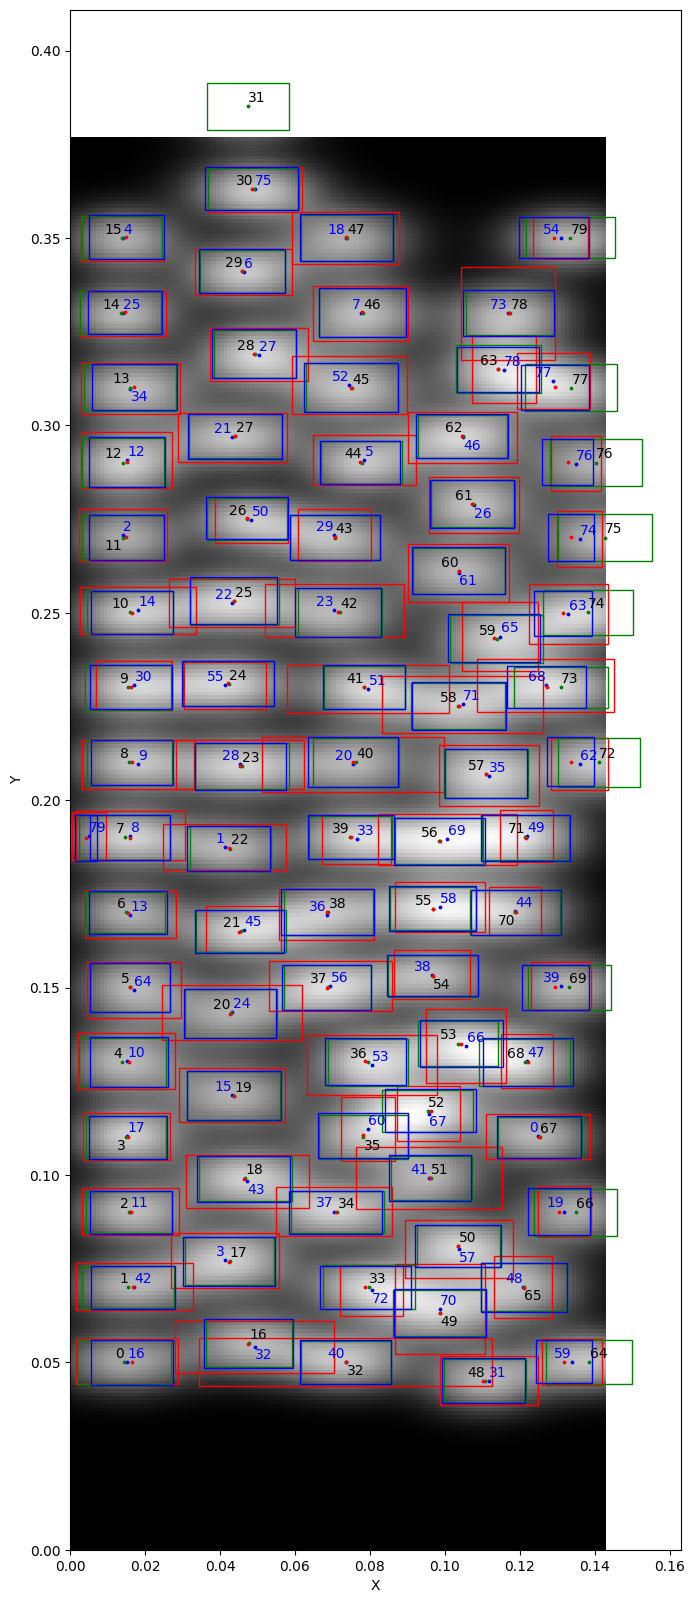

In [ ]:
plt.ion()
plt.show()

### Error evaluation - PX

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[277, 204, 385, 217, 257, 285, 310, 306, 334, 241, 363, 253, 348, 349, 203, 274, 292, 395, 364, 239]


In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - YOLO_px": [],
    "Number identifiable - YOLO_px": [],
    "Percentage - YOLO_px": [],
    "RMSE_cx - YOLO_px": [],
    "RMSE_cy - YOLO_px": [],
    "RMSE_c - YOLO_px": [],
    "RMSE_sigmax - YOLO_px": [],
    "RMSE_sigmay - YOLO_px": [],
    "RMSE_sigma - YOLO_px": [],
    "MaxE_sigmax - YOLO_px": [],
    "MaxE_sigmay - YOLO_px": [],
    "MaxE_sigma - YOLO_px": [],
    "RMSE_amplitude - YOLO_px": [],
    "RMSEPixel - YOLO_px": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        estimation_method="YOLO_px",
        image_path="docs/Data/Images/",
        yolo_model=model,
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 81 gaussians, 299.5ms
Speed: 2.9ms preprocess, 299.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017665           0]
  [          0   0.0095071]]]
covariances true [[[   0.015205           0]
  [          0   0.0088653]]]
[  0.0088653    0.008092   0.0085297   0.0086731   0.0086458   0.0087261   0.0086288    0.008905   0.0090928   0.0080636   0.0086718   0.0091638   0.0080114   0.0087597   0.0086324   0.0083234   0.0087708   0.0086578   0.0090291     0.00829   0.0080466   0.0084427   0.0079471   0.0092807   0.0092982   0.0080415
   0.0091111   0.0088719   0.0084457   0.0083007   0.0086343   0.0086465   0.0079348   0.0081754   0.0092826   0.0082577   0.0087105   0.0079136   0.0084938   0.0087846   0.0083184   0.0084655   0.0092379   0.0079402   0.0079663   0.0078271   0.0092413   0.0092086   0.0088036   0.0090013   0.0087886   0.0081482
   0.0086861   0.0080236   0.0090704   0.0088825   0.0089634   0.0086174   0.0081102     0.00923   0.0090388   0.0087296   0.0079061   0.0079837   0.0082576   0.0090007   0.0077923   0.0084662   0.0086869   0.0079816   0.0087329 


0: 640x256 80 gaussians, 228.0ms
Speed: 2.3ms preprocess, 228.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[     0.0154           0]
  [          0   0.0086478]]]
covariances true [[[   0.015266           0]
  [          0   0.0083557]]]
[  0.0083557   0.0078309   0.0090974   0.0086405   0.0089947   0.0081714   0.0088093   0.0086319   0.0086602   0.0084805   0.0081623   0.0088895   0.0089673    0.009305   0.0080211   0.0089316   0.0080425   0.0090988   0.0093046   0.0087324   0.0079959   0.0080314   0.0083747    0.007862   0.0087074   0.0085817
   0.0085211   0.0085417   0.0092592   0.0085813   0.0091434   0.0087796   0.0082186   0.0086322   0.0078023   0.0078106   0.0086563   0.0081741   0.0086239     0.00789   0.0083659    0.008516   0.0085875   0.0088656   0.0078953   0.0078844   0.0087601   0.0087634   0.0080779   0.0087077    0.007871   0.0080017
   0.0092163    0.008987   0.0081565   0.0083219   0.0085416   0.0090771   0.0082864   0.0085794   0.0090092   0.0079506   0.0085312   0.0089851   0.0093066   0.0086864   0.0090445    0.009177   0.0090966    0.007975   0.0078367 


0: 640x256 79 gaussians, 246.1ms
Speed: 2.0ms preprocess, 246.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015935           0]
  [          0   0.0085356]]]
covariances true [[[   0.015375           0]
  [          0   0.0081417]]]
[  0.0081417   0.0085719   0.0084101   0.0089638   0.0080752   0.0089468   0.0085706   0.0080281   0.0082787   0.0080241   0.0087407   0.0081897   0.0085227   0.0088095    0.008427   0.0082568   0.0083469   0.0086937    0.008594   0.0088114   0.0081366   0.0090927   0.0084632   0.0091254   0.0090201    0.008802
   0.0079019   0.0080747   0.0082534   0.0088663    0.007784   0.0081426    0.008841   0.0093174   0.0086612   0.0085581   0.0079892   0.0087667    0.008744   0.0078634   0.0081935   0.0082666   0.0083622   0.0079421   0.0087203   0.0081256   0.0091847   0.0089593   0.0091786   0.0086978   0.0082731   0.0086265
   0.0087486   0.0084448   0.0090885   0.0083899   0.0081065    0.008858   0.0092092   0.0089296   0.0078271    0.008635   0.0078466    0.009138   0.0084847   0.0082821   0.0082815   0.0085678   0.0092319   0.0088915   0.0082872 


0: 640x256 79 gaussians, 229.4ms
Speed: 3.7ms preprocess, 229.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020916           0]
  [          0    0.010278]]]
covariances true [[[   0.016586           0]
  [          0   0.0088953]]]
[  0.0088953   0.0086979   0.0088241   0.0092608   0.0090789   0.0087953    0.008282   0.0081848   0.0082518   0.0079898   0.0087861   0.0092645    0.008142   0.0090701   0.0089773   0.0090461   0.0081999   0.0079772   0.0083364    0.008939   0.0091941   0.0079321   0.0086228   0.0084139   0.0093026   0.0081251
   0.0078626   0.0086077   0.0083875   0.0082658   0.0078298   0.0083071   0.0092665   0.0088527   0.0083769   0.0092527   0.0087029   0.0078129   0.0080032   0.0093032   0.0089664   0.0089727   0.0084592   0.0082661   0.0079981   0.0086026   0.0084179   0.0086512   0.0078318   0.0082504   0.0088876   0.0083318
    0.008884   0.0088506   0.0080087   0.0091336    0.008903   0.0078935   0.0091654   0.0082491   0.0085284   0.0089558    0.008668   0.0078603   0.0086175   0.0083432    0.009301   0.0078466   0.0086579   0.0078078    0.008002 


0: 640x256 79 gaussians, 259.8ms
Speed: 3.2ms preprocess, 259.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019086           0]
  [          0     0.01031]]]
covariances true [[[   0.017878           0]
  [          0   0.0092539]]]
[  0.0092539    0.009306    0.009063   0.0092858     0.00914   0.0088942   0.0085318   0.0077847   0.0092036   0.0085757   0.0085996   0.0092721   0.0081175   0.0083506    0.008391   0.0078672   0.0089105   0.0083793    0.008474   0.0092137   0.0083194    0.008774   0.0081791   0.0078244   0.0083105   0.0090672
   0.0086694   0.0078432   0.0084366   0.0083264   0.0080525   0.0082392   0.0078313   0.0085857   0.0083886   0.0078518   0.0080897   0.0080987   0.0089104   0.0082117   0.0083073   0.0089669     0.00858    0.009332   0.0079973   0.0084151   0.0093032   0.0087061   0.0082787   0.0082366   0.0085477   0.0083734
   0.0086283   0.0092378   0.0092478   0.0081052   0.0081862   0.0079697   0.0090086   0.0082826   0.0091909   0.0093144     0.00868   0.0079191   0.0084816   0.0079464   0.0081869   0.0088607   0.0088776   0.0082231   0.0082462 


0: 640x256 80 gaussians, 278.4ms
Speed: 2.1ms preprocess, 278.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.01884           0]
  [          0    0.009799]]]
covariances true [[[   0.015869           0]
  [          0   0.0090337]]]
[  0.0090337   0.0084164   0.0088377   0.0086056   0.0091292   0.0082159   0.0089073   0.0087389   0.0092123   0.0091318   0.0079301   0.0083068   0.0079738   0.0091888   0.0089292   0.0087207   0.0085655   0.0078989   0.0086533   0.0093334   0.0090563   0.0078153   0.0086785   0.0090761   0.0080225   0.0081819
   0.0085898   0.0082689   0.0084123   0.0093303   0.0077926    0.007946   0.0090967   0.0078459   0.0087516   0.0079459   0.0090687   0.0079062   0.0090629   0.0092904   0.0089457    0.008003   0.0089579   0.0092523   0.0077956   0.0089431   0.0090394   0.0082176   0.0090063   0.0080723   0.0089395   0.0085258
   0.0091414   0.0090023   0.0087964   0.0083474   0.0091852   0.0086517   0.0091156   0.0084139   0.0079736   0.0078091   0.0092156   0.0082014   0.0091557   0.0089349   0.0080377   0.0080204   0.0086409   0.0080088    0.009109 


0: 640x256 80 gaussians, 413.5ms
Speed: 2.0ms preprocess, 413.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015434           0]
  [          0   0.0096156]]]
covariances true [[[   0.014993           0]
  [          0   0.0087786]]]
[  0.0087786   0.0086977   0.0093247   0.0078836   0.0088717   0.0089654   0.0092385   0.0084034   0.0081402   0.0091553   0.0077921   0.0079258   0.0091721   0.0084426   0.0081484   0.0078563   0.0078148   0.0079242   0.0088833    0.009183   0.0091397   0.0089845   0.0082538   0.0081566   0.0092258   0.0091789
   0.0085734   0.0086317   0.0090068    0.008373   0.0081598   0.0088178   0.0086103   0.0087044   0.0080201   0.0089468   0.0086186   0.0084579   0.0080236   0.0084574    0.009207   0.0083003   0.0080404    0.008755   0.0088871   0.0078546   0.0083207   0.0093222   0.0081434   0.0092817   0.0085759   0.0079157
   0.0087721   0.0083097   0.0086353   0.0089144    0.008374   0.0087584   0.0081243   0.0083155   0.0081997    0.008109   0.0085558   0.0085532    0.008774   0.0081252   0.0090048   0.0091031   0.0079329   0.0086423   0.0085618 


0: 640x256 79 gaussians, 390.0ms
Speed: 2.2ms preprocess, 390.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     0.0174           0]
  [          0     0.00911]]]
covariances true [[[   0.016137           0]
  [          0   0.0089511]]]
[  0.0089511   0.0087966   0.0083591   0.0084777    0.009226   0.0085694   0.0084912   0.0089997   0.0088216   0.0089916   0.0081601   0.0085322   0.0091621   0.0091234   0.0092801   0.0087918   0.0086798    0.008055   0.0086422   0.0086131   0.0090966   0.0087559   0.0077979   0.0084312    0.009298   0.0091762
   0.0087996   0.0078409   0.0092186   0.0084609   0.0080598   0.0079046   0.0080177   0.0083586    0.007982   0.0079656   0.0086667   0.0087367   0.0088788   0.0084191   0.0081921   0.0078394   0.0081107   0.0082817   0.0084324   0.0085202   0.0083244   0.0081449   0.0086943   0.0088413   0.0084949   0.0079502
   0.0079045   0.0091157   0.0090776   0.0080187   0.0081023   0.0083645   0.0089863   0.0080336   0.0082936   0.0090991   0.0079025   0.0078983    0.009234   0.0086255   0.0082454    0.007844   0.0085204   0.0086955   0.0084502 


0: 640x256 79 gaussians, 591.3ms
Speed: 2.2ms preprocess, 591.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018097           0]
  [          0   0.0096241]]]
covariances true [[[    0.01559           0]
  [          0   0.0088846]]]
[  0.0088846   0.0091857   0.0086838   0.0093177   0.0080151   0.0082113   0.0091493   0.0091195   0.0085967    0.007906   0.0090798   0.0087549   0.0083339   0.0092119    0.008348    0.008062   0.0089891   0.0080636   0.0083628    0.009132   0.0084611   0.0084627   0.0087333   0.0083246   0.0080471   0.0083366
   0.0083416   0.0088423   0.0091578   0.0091515   0.0085036   0.0079507   0.0080914   0.0082138   0.0083855   0.0082023   0.0087184   0.0080885   0.0085011   0.0081155   0.0090192   0.0082167   0.0087595    0.008545   0.0079659   0.0082422   0.0086208   0.0088673   0.0082927   0.0079492    0.007852   0.0092166
   0.0089493   0.0084203   0.0085996   0.0078536   0.0083654   0.0087266   0.0089691   0.0092463   0.0080153    0.007908   0.0082931   0.0081072   0.0088154   0.0086241   0.0086752   0.0089676   0.0078627   0.0083312   0.0081062 


0: 640x256 80 gaussians, 875.0ms
Speed: 2.0ms preprocess, 875.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019097           0]
  [          0   0.0095624]]]
covariances true [[[   0.016025           0]
  [          0   0.0086327]]]
[  0.0086327   0.0091911   0.0092588   0.0086664   0.0090212   0.0086449   0.0084144   0.0091515   0.0080398    0.008337    0.008531   0.0084213   0.0079435   0.0079575    0.009056   0.0091225   0.0086477   0.0092375   0.0086085   0.0087869    0.008549   0.0087105   0.0092965   0.0078143   0.0082248   0.0079677
    0.007838   0.0088343   0.0084913   0.0086177   0.0086312   0.0078996   0.0085429   0.0086769   0.0086572   0.0089022   0.0079377   0.0083191   0.0086296   0.0080846   0.0086714   0.0085407   0.0082935    0.008923   0.0089142   0.0092769   0.0079805   0.0078334   0.0090117    0.008046   0.0083027   0.0093093
   0.0088342   0.0084224     0.00906   0.0089079   0.0081969    0.007871   0.0081911   0.0086646   0.0087098   0.0086826   0.0090577   0.0085462    0.008144   0.0091145   0.0079682    0.009092   0.0088653   0.0089567   0.0086614 


0: 640x256 79 gaussians, 672.0ms
Speed: 4.0ms preprocess, 672.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020052           0]
  [          0   0.0088427]]]
covariances true [[[   0.015811           0]
  [          0   0.0082725]]]
[  0.0082725   0.0092517   0.0090651   0.0088413   0.0084428   0.0083009   0.0091322    0.008236   0.0081495   0.0087644   0.0085669   0.0093151   0.0082595    0.008567   0.0079269   0.0089684   0.0082644   0.0083899   0.0078322   0.0078821   0.0081279   0.0088304    0.007977   0.0078689     0.00839   0.0084522
   0.0092853    0.009027   0.0080234   0.0090128   0.0091332   0.0086203   0.0093343   0.0081458    0.008142   0.0086643   0.0086476   0.0082931   0.0079806   0.0089343   0.0081591    0.007958   0.0085598   0.0086884    0.008393   0.0082101   0.0090708   0.0086872   0.0091203    0.008673   0.0081985    0.007963
   0.0088169   0.0079587   0.0080637   0.0078863   0.0087091   0.0086319   0.0089765    0.008509    0.007836   0.0088357   0.0093157   0.0078742   0.0083681   0.0082993   0.0093363   0.0091816   0.0087489   0.0081328   0.0090094 


0: 640x256 80 gaussians, 237.0ms
Speed: 1.9ms preprocess, 237.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017584           0]
  [          0   0.0094163]]]
covariances true [[[   0.016695           0]
  [          0   0.0091382]]]
[  0.0091382   0.0092253   0.0087515    0.008307   0.0087843   0.0081435   0.0084166   0.0084424   0.0084232   0.0093077   0.0090344   0.0086586   0.0087609   0.0082116   0.0080599   0.0088387   0.0089058   0.0084094   0.0086609   0.0080499    0.009058   0.0090911   0.0093129   0.0086227   0.0079596   0.0093184
   0.0082837   0.0089076   0.0080109   0.0087456   0.0088009   0.0082622   0.0081287   0.0083737   0.0087733   0.0083426    0.009048    0.009112   0.0090635   0.0085706   0.0084829   0.0079908   0.0088591   0.0092341    0.008394   0.0090567   0.0087158   0.0079799   0.0079424   0.0085268   0.0080583   0.0087712
    0.008325   0.0084917   0.0091388   0.0082039   0.0087508   0.0080384    0.009208   0.0083254   0.0089117   0.0092789   0.0092655   0.0080595   0.0090261   0.0087078   0.0079006   0.0092834   0.0092878   0.0089449   0.0091361 


0: 640x256 79 gaussians, 238.3ms
Speed: 2.5ms preprocess, 238.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019184           0]
  [          0    0.010103]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]
[  0.0091864   0.0081998   0.0088357   0.0092073   0.0081333   0.0091619   0.0089733   0.0084563   0.0092489   0.0088709   0.0089957   0.0084046   0.0077993   0.0080284   0.0081511   0.0093183   0.0086642   0.0085482   0.0078285   0.0086629   0.0079277   0.0093345   0.0087215   0.0088081   0.0078815   0.0086545
   0.0078728   0.0080544   0.0090825   0.0081713   0.0092532   0.0078075   0.0078844   0.0083276    0.008379    0.009196   0.0092212   0.0090404   0.0089863   0.0088531   0.0081277   0.0087144    0.008182   0.0082907   0.0088356   0.0079705   0.0090879   0.0084432   0.0087237   0.0085656   0.0088676   0.0084929
   0.0081442   0.0083711   0.0084899   0.0085772   0.0081427   0.0084083   0.0089676   0.0081449   0.0084542   0.0087708   0.0086527   0.0082124   0.0082048   0.0082374   0.0092149   0.0088149   0.0087121   0.0082989   0.0079993 


0: 640x256 79 gaussians, 239.6ms
Speed: 3.1ms preprocess, 239.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017731           0]
  [          0   0.0097558]]]
covariances true [[[   0.016137           0]
  [          0   0.0089708]]]
[  0.0089708   0.0091479   0.0082811   0.0085069   0.0091732   0.0078756   0.0084848   0.0091656   0.0080159   0.0081275   0.0088396   0.0087143   0.0083284   0.0079984   0.0080454   0.0089306   0.0091742   0.0085688   0.0085467   0.0080184   0.0079641   0.0081106   0.0086775   0.0080797   0.0090337   0.0091384
   0.0090151   0.0089774   0.0087401   0.0090971   0.0081753   0.0085301   0.0078904    0.008726   0.0078401   0.0079013     0.00779   0.0079963   0.0079115   0.0090902   0.0083783    0.008067   0.0089255   0.0080019      0.0092   0.0078618   0.0087816   0.0087216   0.0079944   0.0084934   0.0082326    0.008675
   0.0089306    0.008024   0.0088625   0.0085025   0.0091851   0.0084036   0.0090627   0.0093238   0.0079455   0.0077943   0.0087367   0.0081914   0.0086179   0.0078365   0.0085996   0.0085055   0.0084712   0.0080296   0.0082884 


0: 640x256 79 gaussians, 223.8ms
Speed: 5.2ms preprocess, 223.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018545           0]
  [          0    0.010095]]]
covariances true [[[   0.016054           0]
  [          0   0.0092144]]]
[  0.0092144   0.0090371   0.0085779   0.0085891   0.0079321   0.0078797   0.0082158   0.0084329   0.0081716   0.0085574   0.0082386   0.0091431   0.0078799   0.0085829    0.008055   0.0092294   0.0086059   0.0078759   0.0090465   0.0078506   0.0084904   0.0082991   0.0082495   0.0084521   0.0084945   0.0078056
   0.0089321   0.0092171   0.0081705   0.0088895   0.0082391   0.0078217    0.007883   0.0082798   0.0086185   0.0083617     0.00929   0.0080666   0.0080803   0.0090104    0.008531   0.0087655   0.0086644   0.0080563   0.0085026   0.0082387   0.0092288   0.0080021    0.007823   0.0084243   0.0079624   0.0090953
   0.0078837   0.0086179   0.0082249   0.0087009    0.009308   0.0085203   0.0089442   0.0078843   0.0088309   0.0090822   0.0084588   0.0078817   0.0089813   0.0090251   0.0088804   0.0079145   0.0082837   0.0084961   0.0081266 


0: 640x256 79 gaussians, 241.0ms
Speed: 2.0ms preprocess, 241.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018478           0]
  [          0   0.0098272]]]
covariances true [[[   0.017192           0]
  [          0   0.0090986]]]
[  0.0090986   0.0086068   0.0086193   0.0090259   0.0085644   0.0092093   0.0082563   0.0092712   0.0093299   0.0089284    0.009112   0.0085521   0.0083249   0.0081311   0.0079852   0.0078976   0.0088954   0.0082229   0.0081059   0.0082441   0.0082057   0.0089852   0.0080453   0.0086871   0.0084081   0.0084613
   0.0082581   0.0079014     0.00864   0.0082824   0.0090417   0.0083144   0.0080963   0.0079987   0.0080175   0.0081437   0.0078196   0.0081219    0.008194   0.0090821   0.0083003   0.0082332   0.0078224   0.0088034    0.009037   0.0080791   0.0088068   0.0082104   0.0085539    0.008439   0.0092372   0.0088329
   0.0083592   0.0082417   0.0078817   0.0086272   0.0079746   0.0077989   0.0085693   0.0084438   0.0092752   0.0083557   0.0085895   0.0079482   0.0084555   0.0081826   0.0090604   0.0081691   0.0083219   0.0083497   0.0085297 


0: 640x256 79 gaussians, 235.9ms
Speed: 2.6ms preprocess, 235.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.023903           0]
  [          0   0.0099175]]]
covariances true [[[   0.016488           0]
  [          0   0.0091941]]]
[  0.0091941   0.0084899   0.0091316   0.0088842    0.008535   0.0084282   0.0090079   0.0089813   0.0091241   0.0085317   0.0088481   0.0082897   0.0092548   0.0085868   0.0081515   0.0080888   0.0090677   0.0092026   0.0088991    0.009298   0.0084785   0.0080574     0.00822   0.0082907   0.0093285   0.0086879
   0.0083793   0.0078616   0.0086381   0.0083687   0.0089255   0.0085636   0.0083416   0.0082568   0.0093102   0.0082771   0.0081523   0.0084643   0.0086007   0.0080581   0.0078704   0.0078169   0.0080902   0.0089696   0.0091621   0.0085462   0.0086617    0.008281   0.0090143   0.0085914   0.0092735   0.0078341
   0.0086796   0.0082905   0.0091533   0.0090661   0.0090326    0.007903   0.0084423   0.0079473   0.0089735   0.0082582   0.0078431   0.0088786    0.008126    0.008469   0.0081487   0.0082526   0.0092709   0.0092022   0.0080389 


0: 640x256 79 gaussians, 397.2ms
Speed: 2.0ms preprocess, 397.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017799           0]
  [          0    0.010116]]]
covariances true [[[   0.016279           0]
  [          0   0.0092726]]]
[  0.0092726   0.0085711   0.0089198   0.0090954   0.0093327     0.00857   0.0079059   0.0085042    0.007944   0.0082528   0.0090259   0.0088078    0.009104   0.0086838    0.007898   0.0085396   0.0080708   0.0092164   0.0093009   0.0089268   0.0087474   0.0079775   0.0088045   0.0089212   0.0091964   0.0090065
   0.0082623   0.0082743   0.0084179   0.0080239   0.0085604   0.0080365   0.0089214   0.0084395   0.0080413    0.007807   0.0084317   0.0089095   0.0081177   0.0083592   0.0086811   0.0080885   0.0078755   0.0092373   0.0091379   0.0080675     0.00809   0.0078496   0.0092387    0.007954   0.0082072   0.0079096
   0.0080317   0.0078614   0.0082246   0.0077914   0.0082992   0.0084618    0.008175   0.0091305   0.0089936   0.0078115   0.0092576   0.0087249   0.0078831   0.0081138   0.0083154   0.0088727   0.0078056   0.0084221   0.0077893 


0: 640x256 80 gaussians, 404.3ms
Speed: 1.9ms preprocess, 404.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017997           0]
  [          0   0.0093906]]]
covariances true [[[   0.016684           0]
  [          0   0.0091856]]]
[  0.0091856   0.0092198   0.0091566   0.0081512    0.009105   0.0078191   0.0089041   0.0082895   0.0085621   0.0091173   0.0089932   0.0091993   0.0085524   0.0092304   0.0087637   0.0088733   0.0089995   0.0086961   0.0087934   0.0081081   0.0082431   0.0083543   0.0087197   0.0084882   0.0080333   0.0081104
   0.0090688   0.0082703   0.0078806   0.0078243   0.0082358    0.009212   0.0078124   0.0078141   0.0084012   0.0081929   0.0087603   0.0082893   0.0087635   0.0078498   0.0086248   0.0087323   0.0079828    0.008699   0.0084762   0.0086388    0.007809   0.0082791   0.0086061   0.0082933   0.0080313    0.008149
   0.0082997   0.0091435   0.0083774   0.0091789   0.0083314   0.0092456   0.0086315   0.0079449   0.0085367   0.0079393   0.0088013   0.0092229   0.0089847   0.0088487   0.0078573   0.0082738   0.0078233   0.0085728   0.0082893 


0: 640x256 79 gaussians, 395.9ms
Speed: 2.1ms preprocess, 395.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017257           0]
  [          0   0.0088812]]]
covariances true [[[   0.015817           0]
  [          0   0.0080224]]]
[  0.0080224   0.0080609   0.0078471   0.0087371   0.0078245   0.0090711   0.0091293   0.0093023   0.0091218   0.0087015    0.009059   0.0084308   0.0092208   0.0083197    0.009084   0.0084207   0.0090273   0.0088102   0.0092063   0.0087561   0.0086196   0.0088785   0.0084273   0.0086529   0.0082293   0.0091828
   0.0091091    0.008023   0.0080142   0.0079348   0.0087715   0.0080905   0.0079375   0.0078741   0.0087182   0.0081605   0.0080227   0.0092304   0.0082637   0.0091554   0.0089153   0.0086825   0.0087617   0.0080001   0.0093059   0.0090095   0.0089922   0.0081695   0.0078576   0.0084848   0.0085994   0.0086922
   0.0087123   0.0085094   0.0078406   0.0089658   0.0081547   0.0084937   0.0081388   0.0084208    0.007857   0.0084514   0.0081328   0.0083018   0.0084829   0.0080502   0.0090897   0.0086076   0.0088699   0.0091126    0.008416 

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,294.80,59.84,395.00
Number identified - YOLO_px,79.40,0.60,81.00
Number identifiable - YOLO_px,79.00,0.00,79.00
Percentage - YOLO_px,100.51,0.76,102.53
RMSE_cx - YOLO_px,2.37,0.21,2.71
RMSE_cy - YOLO_px,0.34,0.02,0.37
RMSE_c - YOLO_px,2.39,0.21,2.73
RMSE_sigmax - YOLO_px,39.34,12.62,83.07
RMSE_sigmay - YOLO_px,19.92,3.85,29.75
RMSE_sigma - YOLO_px,44.40,12.09,85.52


In [ ]:
pd.DataFrame.from_dict(results).round(2)

,Image,Number identified - YOLO_px,Number identifiable - YOLO_px,Percentage - YOLO_px,RMSE_cx - YOLO_px,RMSE_cy - YOLO_px,RMSE_c - YOLO_px,RMSE_sigmax - YOLO_px,RMSE_sigmay - YOLO_px,RMSE_sigma - YOLO_px,MaxE_sigmax - YOLO_px,MaxE_sigmay - YOLO_px,MaxE_sigma - YOLO_px,RMSE_amplitude - YOLO_px,RMSEPixel - YOLO_px
0,277,81,79,102.53,2.46,0.34,2.48,32.62,15.05,35.92,545.83,50.62,548.17,11.15,961098.51
1,204,80,79,101.27,2.28,0.35,2.31,51.40,24.61,56.99,1692.88,312.98,1721.57,13.75,1470921.82
2,385,79,79,100.00,2.71,0.35,2.73,53.47,24.10,58.65,700.90,364.31,789.92,14.81,1613016.63
3,217,79,79,100.00,2.54,0.35,2.56,36.41,29.75,47.02,189.67,1037.41,1054.61,14.52,1445860.91
4,257,79,79,100.00,2.57,0.36,2.59,29.13,21.97,36.48,279.29,197.15,341.86,14.54,1203626.88
5,285,80,79,101.27,2.63,0.34,2.66,34.70,17.22,38.73,614.46,106.46,623.61,13.32,1178680.72
6,310,80,79,101.27,2.35,0.35,2.37,43.96,18.99,47.89,422.01,228.45,479.88,11.80,1392248.86
7,306,79,79,100.00,1.86,0.33,1.89,34.11,23.39,41.36,248.72,296.42,386.94,14.35,1484867.68
8,334,79,79,100.00,2.36,0.31,2.38,35.35,16.88,39.18,507.35,155.16,530.55,11.61,1015781.13
9,241,80,79,101.27,2.36,0.34,2.39,24.57,16.14,29.40,129.05,90.74,157.75,13.41,830105.82


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""..docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"docs/Data/Images/"}\n
                 id_estimation_method = {"YOLO PX"}\n
                 id_images evaluated: {eval_images}""",
    name="E2YOLOPX",
)

## Evaluate - Plot Truth, YOLO and PX infer

In [68]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, figsize=(25, 20))
all_texts = []

In [69]:
# Original image
plot_grayscale(x, y, mat["F_data"][:, :, n_image], colorbar=False, ax=ax)

In [70]:
# Plot box and center - from pipeline with PX estimation covariance
all_texts = all_texts + plot_box_labels(
    image,
    [(x, y) for x, y in converted_new_means_infer],
    [
        (wx, wy)
        for wx, wy in zip(
            np.sqrt(new_covariances_infer[:, 0, 0]),
            np.sqrt(new_covariances_infer[:, 1, 1]),
        )
    ],
    ax=ax,
    box_edge_color="#0343DF",  # BOX COLOR
    center_color="#0343DF",  # CENTER COLOR
    annotate_gaussians=True,
    text_color="blue",
)

In [71]:
# Plot box and center - TRUE
all_texts = all_texts + plot_box_labels(
    image,
    list(zip(xs, ys)),
    list(zip(dispersion_x, dispersion_y)),
    ax=ax,
    box_edge_color="r",  # BOX COLOR
    center_color="r",  # CENTER COLOR
    annotate_gaussians=True,
)

In [72]:
# Plot box and center -  YOLO
plot_box_labels(
    image,
    [(x, y) for x, y in means],
    [
        (wx, wy)
        for wx, wy in zip(np.sqrt(covariances[:, 0, 0]), np.sqrt(covariances[:, 1, 1]))
    ],
    ax=ax,
    box_edge_color="g",  # BOX COLOR
    center_color="g",  # CENTER COLOR
    annotate_gaussians=False,
)

In [73]:
ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor("gray")
    spine.set_linewidth(1)

ax.set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
ax.set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])

(0.0, 0.143)

In [74]:
ax.xaxis.label.set_text("")
ax.yaxis.label.set_text("")

ax.set_xticks([])
ax.set_yticks([])
# Change the color of the axis spines (borders)
for spine in ax.spines.values():
    spine.set_edgecolor("gray")
    spine.set_linewidth(1)

ax.set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
ax.set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])

(0.0, 0.143)

In [75]:
adjust_text(all_texts)

5

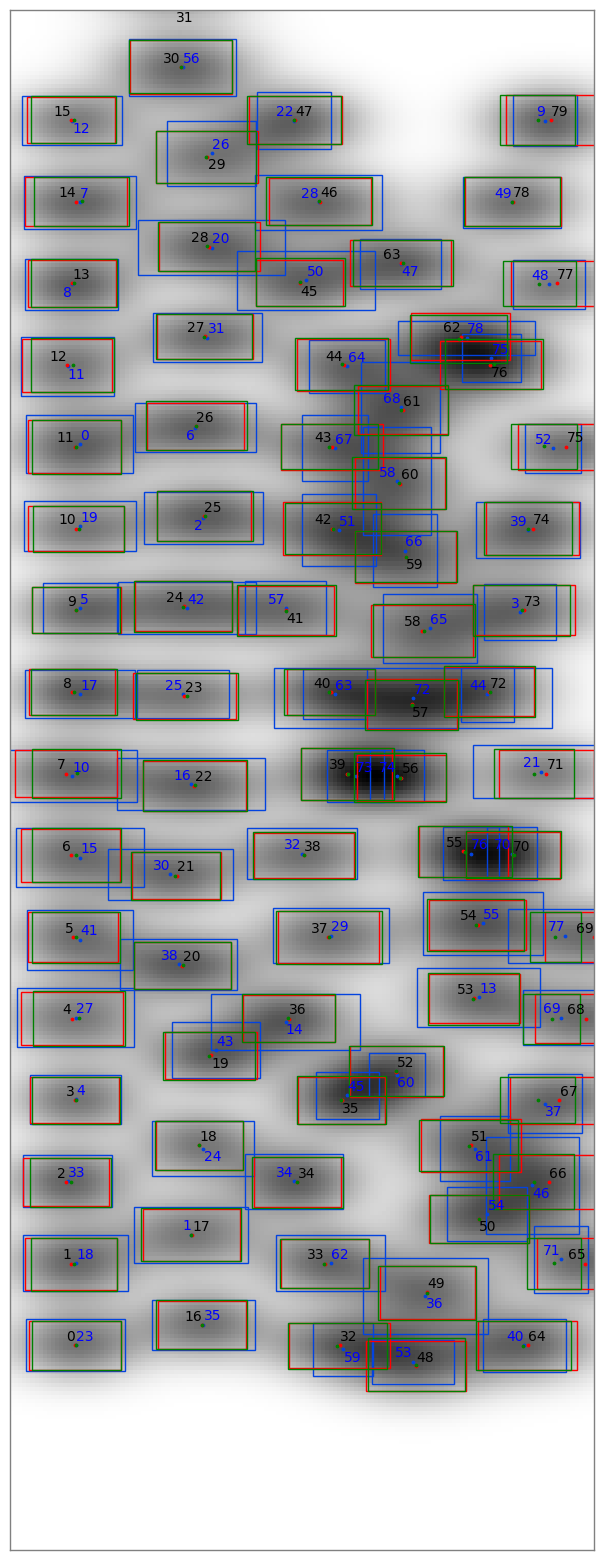

In [76]:
plt.ion()
plt.show()

### Error evaluation - PX Infer

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[277, 204, 385, 217, 257, 285, 310, 306, 334, 241, 363, 253, 348, 349, 203, 274, 292, 395, 364, 239]


In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - YOLO_px_infer": [],
    "Number identifiable - YOLO_px_infer": [],
    "Percentage - YOLO_px_infer": [],
    "RMSE_cx - YOLO_px_infer": [],
    "RMSE_cy - YOLO_px_infer": [],
    "RMSE_c - YOLO_px_infer": [],
    "RMSE_sigmax - YOLO_px_infer": [],
    "RMSE_sigmay - YOLO_px_infer": [],
    "RMSE_sigma - YOLO_px_infer": [],
    "MaxE_sigmax - YOLO_px_infer": [],
    "MaxE_sigmay - YOLO_px_infer": [],
    "MaxE_sigma - YOLO_px_infer": [],
    "RMSE_amplitude - YOLO_px_infer": [],
    "RMSEPixel - YOLO_px_infer": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        estimation_method="YOLO_px_infer",
        image_path="docs/Data/Images/",
        yolo_model=model,
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 81 gaussians, 591.5ms
Speed: 2.0ms preprocess, 591.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017665           0]
  [          0   0.0095071]]]
covariances true [[[   0.015205           0]
  [          0   0.0088653]]]
[  0.0088653    0.008092   0.0085297   0.0086731   0.0086458   0.0087261   0.0086288    0.008905   0.0090928   0.0080636   0.0086718   0.0091638   0.0080114   0.0087597   0.0086324   0.0083234   0.0087708   0.0086578   0.0090291     0.00829   0.0080466   0.0084427   0.0079471   0.0092807   0.0092982   0.0080415
   0.0091111   0.0088719   0.0084457   0.0083007   0.0086343   0.0086465   0.0079348   0.0081754   0.0092826   0.0082577   0.0087105   0.0079136   0.0084938   0.0087846   0.0083184   0.0084655   0.0092379   0.0079402   0.0079663   0.0078271   0.0092413   0.0092086   0.0088036   0.0090013   0.0087886   0.0081482
   0.0086861   0.0080236   0.0090704   0.0088825   0.0089634   0.0086174   0.0081102     0.00923   0.0090388   0.0087296   0.0079061   0.0079837   0.0082576   0.0090007   0.0077923   0.0084662   0.0086869   0.0079816   0.0087329 


0: 640x256 80 gaussians, 425.4ms
Speed: 3.5ms preprocess, 425.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[     0.0154           0]
  [          0   0.0086478]]]
covariances true [[[   0.015266           0]
  [          0   0.0083557]]]
[  0.0083557   0.0078309   0.0090974   0.0086405   0.0089947   0.0081714   0.0088093   0.0086319   0.0086602   0.0084805   0.0081623   0.0088895   0.0089673    0.009305   0.0080211   0.0089316   0.0080425   0.0090988   0.0093046   0.0087324   0.0079959   0.0080314   0.0083747    0.007862   0.0087074   0.0085817
   0.0085211   0.0085417   0.0092592   0.0085813   0.0091434   0.0087796   0.0082186   0.0086322   0.0078023   0.0078106   0.0086563   0.0081741   0.0086239     0.00789   0.0083659    0.008516   0.0085875   0.0088656   0.0078953   0.0078844   0.0087601   0.0087634   0.0080779   0.0087077    0.007871   0.0080017
   0.0092163    0.008987   0.0081565   0.0083219   0.0085416   0.0090771   0.0082864   0.0085794   0.0090092   0.0079506   0.0085312   0.0089851   0.0093066   0.0086864   0.0090445    0.009177   0.0090966    0.007975   0.0078367 


0: 640x256 79 gaussians, 381.5ms
Speed: 1.9ms preprocess, 381.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015935           0]
  [          0   0.0085356]]]
covariances true [[[   0.015375           0]
  [          0   0.0081417]]]
[  0.0081417   0.0085719   0.0084101   0.0089638   0.0080752   0.0089468   0.0085706   0.0080281   0.0082787   0.0080241   0.0087407   0.0081897   0.0085227   0.0088095    0.008427   0.0082568   0.0083469   0.0086937    0.008594   0.0088114   0.0081366   0.0090927   0.0084632   0.0091254   0.0090201    0.008802
   0.0079019   0.0080747   0.0082534   0.0088663    0.007784   0.0081426    0.008841   0.0093174   0.0086612   0.0085581   0.0079892   0.0087667    0.008744   0.0078634   0.0081935   0.0082666   0.0083622   0.0079421   0.0087203   0.0081256   0.0091847   0.0089593   0.0091786   0.0086978   0.0082731   0.0086265
   0.0087486   0.0084448   0.0090885   0.0083899   0.0081065    0.008858   0.0092092   0.0089296   0.0078271    0.008635   0.0078466    0.009138   0.0084847   0.0082821   0.0082815   0.0085678   0.0092319   0.0088915   0.0082872 


0: 640x256 79 gaussians, 280.3ms
Speed: 2.0ms preprocess, 280.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020916           0]
  [          0    0.010278]]]
covariances true [[[   0.016586           0]
  [          0   0.0088953]]]
[  0.0088953   0.0086979   0.0088241   0.0092608   0.0090789   0.0087953    0.008282   0.0081848   0.0082518   0.0079898   0.0087861   0.0092645    0.008142   0.0090701   0.0089773   0.0090461   0.0081999   0.0079772   0.0083364    0.008939   0.0091941   0.0079321   0.0086228   0.0084139   0.0093026   0.0081251
   0.0078626   0.0086077   0.0083875   0.0082658   0.0078298   0.0083071   0.0092665   0.0088527   0.0083769   0.0092527   0.0087029   0.0078129   0.0080032   0.0093032   0.0089664   0.0089727   0.0084592   0.0082661   0.0079981   0.0086026   0.0084179   0.0086512   0.0078318   0.0082504   0.0088876   0.0083318
    0.008884   0.0088506   0.0080087   0.0091336    0.008903   0.0078935   0.0091654   0.0082491   0.0085284   0.0089558    0.008668   0.0078603   0.0086175   0.0083432    0.009301   0.0078466   0.0086579   0.0078078    0.008002 


0: 640x256 79 gaussians, 244.4ms
Speed: 2.9ms preprocess, 244.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019086           0]
  [          0     0.01031]]]
covariances true [[[   0.017878           0]
  [          0   0.0092539]]]
[  0.0092539    0.009306    0.009063   0.0092858     0.00914   0.0088942   0.0085318   0.0077847   0.0092036   0.0085757   0.0085996   0.0092721   0.0081175   0.0083506    0.008391   0.0078672   0.0089105   0.0083793    0.008474   0.0092137   0.0083194    0.008774   0.0081791   0.0078244   0.0083105   0.0090672
   0.0086694   0.0078432   0.0084366   0.0083264   0.0080525   0.0082392   0.0078313   0.0085857   0.0083886   0.0078518   0.0080897   0.0080987   0.0089104   0.0082117   0.0083073   0.0089669     0.00858    0.009332   0.0079973   0.0084151   0.0093032   0.0087061   0.0082787   0.0082366   0.0085477   0.0083734
   0.0086283   0.0092378   0.0092478   0.0081052   0.0081862   0.0079697   0.0090086   0.0082826   0.0091909   0.0093144     0.00868   0.0079191   0.0084816   0.0079464   0.0081869   0.0088607   0.0088776   0.0082231   0.0082462 


0: 640x256 80 gaussians, 246.5ms
Speed: 3.4ms preprocess, 246.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.01884           0]
  [          0    0.009799]]]
covariances true [[[   0.015869           0]
  [          0   0.0090337]]]
[  0.0090337   0.0084164   0.0088377   0.0086056   0.0091292   0.0082159   0.0089073   0.0087389   0.0092123   0.0091318   0.0079301   0.0083068   0.0079738   0.0091888   0.0089292   0.0087207   0.0085655   0.0078989   0.0086533   0.0093334   0.0090563   0.0078153   0.0086785   0.0090761   0.0080225   0.0081819
   0.0085898   0.0082689   0.0084123   0.0093303   0.0077926    0.007946   0.0090967   0.0078459   0.0087516   0.0079459   0.0090687   0.0079062   0.0090629   0.0092904   0.0089457    0.008003   0.0089579   0.0092523   0.0077956   0.0089431   0.0090394   0.0082176   0.0090063   0.0080723   0.0089395   0.0085258
   0.0091414   0.0090023   0.0087964   0.0083474   0.0091852   0.0086517   0.0091156   0.0084139   0.0079736   0.0078091   0.0092156   0.0082014   0.0091557   0.0089349   0.0080377   0.0080204   0.0086409   0.0080088    0.009109 


0: 640x256 80 gaussians, 238.7ms
Speed: 2.5ms preprocess, 238.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015434           0]
  [          0   0.0096156]]]
covariances true [[[   0.014993           0]
  [          0   0.0087786]]]
[  0.0087786   0.0086977   0.0093247   0.0078836   0.0088717   0.0089654   0.0092385   0.0084034   0.0081402   0.0091553   0.0077921   0.0079258   0.0091721   0.0084426   0.0081484   0.0078563   0.0078148   0.0079242   0.0088833    0.009183   0.0091397   0.0089845   0.0082538   0.0081566   0.0092258   0.0091789
   0.0085734   0.0086317   0.0090068    0.008373   0.0081598   0.0088178   0.0086103   0.0087044   0.0080201   0.0089468   0.0086186   0.0084579   0.0080236   0.0084574    0.009207   0.0083003   0.0080404    0.008755   0.0088871   0.0078546   0.0083207   0.0093222   0.0081434   0.0092817   0.0085759   0.0079157
   0.0087721   0.0083097   0.0086353   0.0089144    0.008374   0.0087584   0.0081243   0.0083155   0.0081997    0.008109   0.0085558   0.0085532    0.008774   0.0081252   0.0090048   0.0091031   0.0079329   0.0086423   0.0085618 


0: 640x256 79 gaussians, 228.1ms
Speed: 5.2ms preprocess, 228.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[     0.0174           0]
  [          0     0.00911]]]
covariances true [[[   0.016137           0]
  [          0   0.0089511]]]
[  0.0089511   0.0087966   0.0083591   0.0084777    0.009226   0.0085694   0.0084912   0.0089997   0.0088216   0.0089916   0.0081601   0.0085322   0.0091621   0.0091234   0.0092801   0.0087918   0.0086798    0.008055   0.0086422   0.0086131   0.0090966   0.0087559   0.0077979   0.0084312    0.009298   0.0091762
   0.0087996   0.0078409   0.0092186   0.0084609   0.0080598   0.0079046   0.0080177   0.0083586    0.007982   0.0079656   0.0086667   0.0087367   0.0088788   0.0084191   0.0081921   0.0078394   0.0081107   0.0082817   0.0084324   0.0085202   0.0083244   0.0081449   0.0086943   0.0088413   0.0084949   0.0079502
   0.0079045   0.0091157   0.0090776   0.0080187   0.0081023   0.0083645   0.0089863   0.0080336   0.0082936   0.0090991   0.0079025   0.0078983    0.009234   0.0086255   0.0082454    0.007844   0.0085204   0.0086955   0.0084502 


0: 640x256 79 gaussians, 241.1ms
Speed: 1.7ms preprocess, 241.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018097           0]
  [          0   0.0096241]]]
covariances true [[[    0.01559           0]
  [          0   0.0088846]]]
[  0.0088846   0.0091857   0.0086838   0.0093177   0.0080151   0.0082113   0.0091493   0.0091195   0.0085967    0.007906   0.0090798   0.0087549   0.0083339   0.0092119    0.008348    0.008062   0.0089891   0.0080636   0.0083628    0.009132   0.0084611   0.0084627   0.0087333   0.0083246   0.0080471   0.0083366
   0.0083416   0.0088423   0.0091578   0.0091515   0.0085036   0.0079507   0.0080914   0.0082138   0.0083855   0.0082023   0.0087184   0.0080885   0.0085011   0.0081155   0.0090192   0.0082167   0.0087595    0.008545   0.0079659   0.0082422   0.0086208   0.0088673   0.0082927   0.0079492    0.007852   0.0092166
   0.0089493   0.0084203   0.0085996   0.0078536   0.0083654   0.0087266   0.0089691   0.0092463   0.0080153    0.007908   0.0082931   0.0081072   0.0088154   0.0086241   0.0086752   0.0089676   0.0078627   0.0083312   0.0081062 


0: 640x256 80 gaussians, 335.5ms
Speed: 1.5ms preprocess, 335.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.019097           0]
  [          0   0.0095624]]]
covariances true [[[   0.016025           0]
  [          0   0.0086327]]]
[  0.0086327   0.0091911   0.0092588   0.0086664   0.0090212   0.0086449   0.0084144   0.0091515   0.0080398    0.008337    0.008531   0.0084213   0.0079435   0.0079575    0.009056   0.0091225   0.0086477   0.0092375   0.0086085   0.0087869    0.008549   0.0087105   0.0092965   0.0078143   0.0082248   0.0079677
    0.007838   0.0088343   0.0084913   0.0086177   0.0086312   0.0078996   0.0085429   0.0086769   0.0086572   0.0089022   0.0079377   0.0083191   0.0086296   0.0080846   0.0086714   0.0085407   0.0082935    0.008923   0.0089142   0.0092769   0.0079805   0.0078334   0.0090117    0.008046   0.0083027   0.0093093
   0.0088342   0.0084224     0.00906   0.0089079   0.0081969    0.007871   0.0081911   0.0086646   0.0087098   0.0086826   0.0090577   0.0085462    0.008144   0.0091145   0.0079682    0.009092   0.0088653   0.0089567   0.0086614 


0: 640x256 79 gaussians, 396.4ms
Speed: 1.9ms preprocess, 396.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.020052           0]
  [          0   0.0088427]]]
covariances true [[[   0.015811           0]
  [          0   0.0082725]]]
[  0.0082725   0.0092517   0.0090651   0.0088413   0.0084428   0.0083009   0.0091322    0.008236   0.0081495   0.0087644   0.0085669   0.0093151   0.0082595    0.008567   0.0079269   0.0089684   0.0082644   0.0083899   0.0078322   0.0078821   0.0081279   0.0088304    0.007977   0.0078689     0.00839   0.0084522
   0.0092853    0.009027   0.0080234   0.0090128   0.0091332   0.0086203   0.0093343   0.0081458    0.008142   0.0086643   0.0086476   0.0082931   0.0079806   0.0089343   0.0081591    0.007958   0.0085598   0.0086884    0.008393   0.0082101   0.0090708   0.0086872   0.0091203    0.008673   0.0081985    0.007963
   0.0088169   0.0079587   0.0080637   0.0078863   0.0087091   0.0086319   0.0089765    0.008509    0.007836   0.0088357   0.0093157   0.0078742   0.0083681   0.0082993   0.0093363   0.0091816   0.0087489   0.0081328   0.0090094 


0: 640x256 80 gaussians, 580.9ms
Speed: 2.0ms preprocess, 580.9ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017584           0]
  [          0   0.0094163]]]
covariances true [[[   0.016695           0]
  [          0   0.0091382]]]
[  0.0091382   0.0092253   0.0087515    0.008307   0.0087843   0.0081435   0.0084166   0.0084424   0.0084232   0.0093077   0.0090344   0.0086586   0.0087609   0.0082116   0.0080599   0.0088387   0.0089058   0.0084094   0.0086609   0.0080499    0.009058   0.0090911   0.0093129   0.0086227   0.0079596   0.0093184
   0.0082837   0.0089076   0.0080109   0.0087456   0.0088009   0.0082622   0.0081287   0.0083737   0.0087733   0.0083426    0.009048    0.009112   0.0090635   0.0085706   0.0084829   0.0079908   0.0088591   0.0092341    0.008394   0.0090567   0.0087158   0.0079799   0.0079424   0.0085268   0.0080583   0.0087712
    0.008325   0.0084917   0.0091388   0.0082039   0.0087508   0.0080384    0.009208   0.0083254   0.0089117   0.0092789   0.0092655   0.0080595   0.0090261   0.0087078   0.0079006   0.0092834   0.0092878   0.0089449   0.0091361 


0: 640x256 79 gaussians, 611.0ms
Speed: 2.9ms preprocess, 611.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.019184           0]
  [          0    0.010103]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]
[  0.0091864   0.0081998   0.0088357   0.0092073   0.0081333   0.0091619   0.0089733   0.0084563   0.0092489   0.0088709   0.0089957   0.0084046   0.0077993   0.0080284   0.0081511   0.0093183   0.0086642   0.0085482   0.0078285   0.0086629   0.0079277   0.0093345   0.0087215   0.0088081   0.0078815   0.0086545
   0.0078728   0.0080544   0.0090825   0.0081713   0.0092532   0.0078075   0.0078844   0.0083276    0.008379    0.009196   0.0092212   0.0090404   0.0089863   0.0088531   0.0081277   0.0087144    0.008182   0.0082907   0.0088356   0.0079705   0.0090879   0.0084432   0.0087237   0.0085656   0.0088676   0.0084929
   0.0081442   0.0083711   0.0084899   0.0085772   0.0081427   0.0084083   0.0089676   0.0081449   0.0084542   0.0087708   0.0086527   0.0082124   0.0082048   0.0082374   0.0092149   0.0088149   0.0087121   0.0082989   0.0079993 


0: 640x256 79 gaussians, 407.4ms
Speed: 2.0ms preprocess, 407.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017731           0]
  [          0   0.0097558]]]
covariances true [[[   0.016137           0]
  [          0   0.0089708]]]
[  0.0089708   0.0091479   0.0082811   0.0085069   0.0091732   0.0078756   0.0084848   0.0091656   0.0080159   0.0081275   0.0088396   0.0087143   0.0083284   0.0079984   0.0080454   0.0089306   0.0091742   0.0085688   0.0085467   0.0080184   0.0079641   0.0081106   0.0086775   0.0080797   0.0090337   0.0091384
   0.0090151   0.0089774   0.0087401   0.0090971   0.0081753   0.0085301   0.0078904    0.008726   0.0078401   0.0079013     0.00779   0.0079963   0.0079115   0.0090902   0.0083783    0.008067   0.0089255   0.0080019      0.0092   0.0078618   0.0087816   0.0087216   0.0079944   0.0084934   0.0082326    0.008675
   0.0089306    0.008024   0.0088625   0.0085025   0.0091851   0.0084036   0.0090627   0.0093238   0.0079455   0.0077943   0.0087367   0.0081914   0.0086179   0.0078365   0.0085996   0.0085055   0.0084712   0.0080296   0.0082884 


0: 640x256 79 gaussians, 374.6ms
Speed: 2.3ms preprocess, 374.6ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018545           0]
  [          0    0.010095]]]
covariances true [[[   0.016054           0]
  [          0   0.0092144]]]
[  0.0092144   0.0090371   0.0085779   0.0085891   0.0079321   0.0078797   0.0082158   0.0084329   0.0081716   0.0085574   0.0082386   0.0091431   0.0078799   0.0085829    0.008055   0.0092294   0.0086059   0.0078759   0.0090465   0.0078506   0.0084904   0.0082991   0.0082495   0.0084521   0.0084945   0.0078056
   0.0089321   0.0092171   0.0081705   0.0088895   0.0082391   0.0078217    0.007883   0.0082798   0.0086185   0.0083617     0.00929   0.0080666   0.0080803   0.0090104    0.008531   0.0087655   0.0086644   0.0080563   0.0085026   0.0082387   0.0092288   0.0080021    0.007823   0.0084243   0.0079624   0.0090953
   0.0078837   0.0086179   0.0082249   0.0087009    0.009308   0.0085203   0.0089442   0.0078843   0.0088309   0.0090822   0.0084588   0.0078817   0.0089813   0.0090251   0.0088804   0.0079145   0.0082837   0.0084961   0.0081266 


0: 640x256 79 gaussians, 384.5ms
Speed: 4.5ms preprocess, 384.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.018478           0]
  [          0   0.0098272]]]
covariances true [[[   0.017192           0]
  [          0   0.0090986]]]
[  0.0090986   0.0086068   0.0086193   0.0090259   0.0085644   0.0092093   0.0082563   0.0092712   0.0093299   0.0089284    0.009112   0.0085521   0.0083249   0.0081311   0.0079852   0.0078976   0.0088954   0.0082229   0.0081059   0.0082441   0.0082057   0.0089852   0.0080453   0.0086871   0.0084081   0.0084613
   0.0082581   0.0079014     0.00864   0.0082824   0.0090417   0.0083144   0.0080963   0.0079987   0.0080175   0.0081437   0.0078196   0.0081219    0.008194   0.0090821   0.0083003   0.0082332   0.0078224   0.0088034    0.009037   0.0080791   0.0088068   0.0082104   0.0085539    0.008439   0.0092372   0.0088329
   0.0083592   0.0082417   0.0078817   0.0086272   0.0079746   0.0077989   0.0085693   0.0084438   0.0092752   0.0083557   0.0085895   0.0079482   0.0084555   0.0081826   0.0090604   0.0081691   0.0083219   0.0083497   0.0085297 


0: 640x256 79 gaussians, 413.1ms
Speed: 1.9ms preprocess, 413.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.023903           0]
  [          0   0.0099175]]]
covariances true [[[   0.016488           0]
  [          0   0.0091941]]]
[  0.0091941   0.0084899   0.0091316   0.0088842    0.008535   0.0084282   0.0090079   0.0089813   0.0091241   0.0085317   0.0088481   0.0082897   0.0092548   0.0085868   0.0081515   0.0080888   0.0090677   0.0092026   0.0088991    0.009298   0.0084785   0.0080574     0.00822   0.0082907   0.0093285   0.0086879
   0.0083793   0.0078616   0.0086381   0.0083687   0.0089255   0.0085636   0.0083416   0.0082568   0.0093102   0.0082771   0.0081523   0.0084643   0.0086007   0.0080581   0.0078704   0.0078169   0.0080902   0.0089696   0.0091621   0.0085462   0.0086617    0.008281   0.0090143   0.0085914   0.0092735   0.0078341
   0.0086796   0.0082905   0.0091533   0.0090661   0.0090326    0.007903   0.0084423   0.0079473   0.0089735   0.0082582   0.0078431   0.0088786    0.008126    0.008469   0.0081487   0.0082526   0.0092709   0.0092022   0.0080389 


0: 640x256 79 gaussians, 406.1ms
Speed: 3.1ms preprocess, 406.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017799           0]
  [          0    0.010116]]]
covariances true [[[   0.016279           0]
  [          0   0.0092726]]]
[  0.0092726   0.0085711   0.0089198   0.0090954   0.0093327     0.00857   0.0079059   0.0085042    0.007944   0.0082528   0.0090259   0.0088078    0.009104   0.0086838    0.007898   0.0085396   0.0080708   0.0092164   0.0093009   0.0089268   0.0087474   0.0079775   0.0088045   0.0089212   0.0091964   0.0090065
   0.0082623   0.0082743   0.0084179   0.0080239   0.0085604   0.0080365   0.0089214   0.0084395   0.0080413    0.007807   0.0084317   0.0089095   0.0081177   0.0083592   0.0086811   0.0080885   0.0078755   0.0092373   0.0091379   0.0080675     0.00809   0.0078496   0.0092387    0.007954   0.0082072   0.0079096
   0.0080317   0.0078614   0.0082246   0.0077914   0.0082992   0.0084618    0.008175   0.0091305   0.0089936   0.0078115   0.0092576   0.0087249   0.0078831   0.0081138   0.0083154   0.0088727   0.0078056   0.0084221   0.0077893 


0: 640x256 80 gaussians, 405.0ms
Speed: 1.9ms preprocess, 405.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.017997           0]
  [          0   0.0093906]]]
covariances true [[[   0.016684           0]
  [          0   0.0091856]]]
[  0.0091856   0.0092198   0.0091566   0.0081512    0.009105   0.0078191   0.0089041   0.0082895   0.0085621   0.0091173   0.0089932   0.0091993   0.0085524   0.0092304   0.0087637   0.0088733   0.0089995   0.0086961   0.0087934   0.0081081   0.0082431   0.0083543   0.0087197   0.0084882   0.0080333   0.0081104
   0.0090688   0.0082703   0.0078806   0.0078243   0.0082358    0.009212   0.0078124   0.0078141   0.0084012   0.0081929   0.0087603   0.0082893   0.0087635   0.0078498   0.0086248   0.0087323   0.0079828    0.008699   0.0084762   0.0086388    0.007809   0.0082791   0.0086061   0.0082933   0.0080313    0.008149
   0.0082997   0.0091435   0.0083774   0.0091789   0.0083314   0.0092456   0.0086315   0.0079449   0.0085367   0.0079393   0.0088013   0.0092229   0.0089847   0.0088487   0.0078573   0.0082738   0.0078233   0.0085728   0.0082893 


0: 640x256 79 gaussians, 390.8ms
Speed: 2.0ms preprocess, 390.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.017257           0]
  [          0   0.0088812]]]
covariances true [[[   0.015817           0]
  [          0   0.0080224]]]
[  0.0080224   0.0080609   0.0078471   0.0087371   0.0078245   0.0090711   0.0091293   0.0093023   0.0091218   0.0087015    0.009059   0.0084308   0.0092208   0.0083197    0.009084   0.0084207   0.0090273   0.0088102   0.0092063   0.0087561   0.0086196   0.0088785   0.0084273   0.0086529   0.0082293   0.0091828
   0.0091091    0.008023   0.0080142   0.0079348   0.0087715   0.0080905   0.0079375   0.0078741   0.0087182   0.0081605   0.0080227   0.0092304   0.0082637   0.0091554   0.0089153   0.0086825   0.0087617   0.0080001   0.0093059   0.0090095   0.0089922   0.0081695   0.0078576   0.0084848   0.0085994   0.0086922
   0.0087123   0.0085094   0.0078406   0.0089658   0.0081547   0.0084937   0.0081388   0.0084208    0.007857   0.0084514   0.0081328   0.0083018   0.0084829   0.0080502   0.0090897   0.0086076   0.0088699   0.0091126    0.008416 

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,294.80,59.84,395.00
Number identified - YOLO_px_infer,79.40,0.60,81.00
Number identifiable - YOLO_px_infer,79.00,0.00,79.00
Percentage - YOLO_px_infer,100.51,0.76,102.53
RMSE_cx - YOLO_px_infer,2.37,0.21,2.71
RMSE_cy - YOLO_px_infer,0.34,0.02,0.37
RMSE_c - YOLO_px_infer,2.39,0.21,2.73
RMSE_sigmax - YOLO_px_infer,23.31,1.81,26.36
RMSE_sigmay - YOLO_px_infer,14.53,1.21,16.20
RMSE_sigma - YOLO_px_infer,27.49,1.86,30.93


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"docs/Data/Images/"}\n
                 id_estimation_method = {"YOLO PX INFER"}\n
                 id_images evaluated: {eval_images}""",
    name="E2YOLOPXINFER",
)

## [ESTIMATION] Pipeline ensembled (PX Modified and YOLO)

In [ ]:
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
(amplitude, xs, ys, dispersion_x, dispersion_y) = parameters_extract(
    mat["Fit_flux"], n_image
)

#### ERROR MSEP evaluation - YOLO + Refinning -
- Compare values by reconstruction with the estimated parameters (per Gaussian)

##### Each Gaussian error estimation

In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [
    np.array([[(wx / (np.sqrt(2))) ** 2, 0], [0, (wy / (np.sqrt(2))) ** 2]])
    for wx, wy in zip(dispersion_x, dispersion_y)
]
amplitudes_truth = amplitude
(
    all_gaussians_truth,
    generated_z_truth,
    rmsep_truth,
    error_gaussians_truth,
) = compute_error_per_gaussian(image, means_truth, covariances_truth, amplitudes_truth)

Gaussian 30 center is out of bounds
Gaussian 79 center is out of bounds


In [ ]:
# Compute YOLO
(
    all_gaussians_yolo,
    generated_z_yolo,
    rmsep_yolo,
    error_gaussians_yolo,
) = compute_error_per_gaussian(image, means, list(covariances / 2), amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(
    all_gaussians_px,
    generated_z_px,
    rmsep_px,
    error_gaussians_px,
) = compute_error_per_gaussian(
    image, converted_new_means, list(new_covariances / 2), amplitudes_px
)

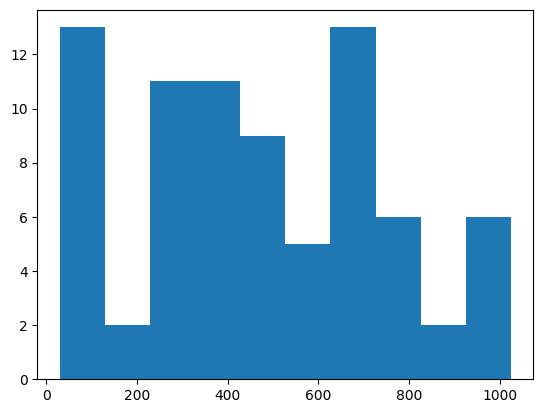

In [ ]:
# Error Yolo
plt.hist(error_gaussians_truth)
plt.show()

Max error gaussian = 72
Min error gaussian = 14


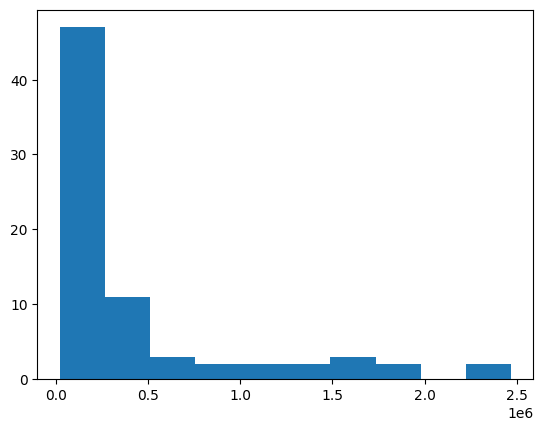

In [ ]:
# Error Yolo
plt.hist(error_gaussians_yolo)

# Gaussian min / max error
print(f"Max error gaussian = {np.argmax(np.array(error_gaussians_yolo))}")
print(f"Min error gaussian = {np.argmin(np.array(error_gaussians_yolo))}")

Max error gaussian = 70
Min error gaussian = 27


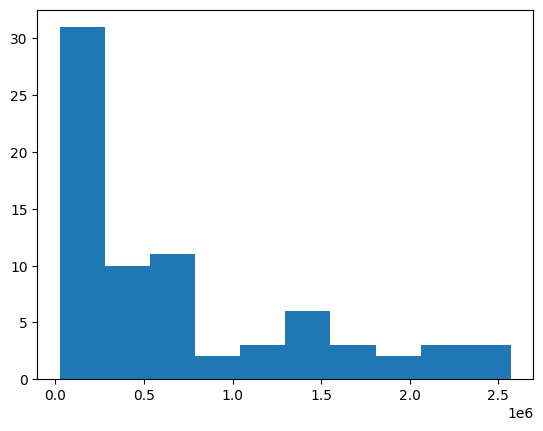

In [ ]:
# Error PX
plt.hist(error_gaussians_px)

# Gaussian min / max error
print(f"Max error gaussian = {np.argmax(np.array(error_gaussians_px))}")
print(f"Min error gaussian = {np.argmin(np.array(error_gaussians_px))}")

### Error evaluation ensemble Yolo and PX modified

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[277, 204, 385, 217, 257, 285, 310, 306, 334, 241, 363, 253, 348, 349, 203, 274, 292, 395, 364, 239]


In [ ]:
# Iterate all images - ensembled method
results = {
    "Image": [],
    "Number identified - ensembled": [],
    "Number identifiable - ensembled": [],
    "Percentage - ensembled": [],
    "RMSE_cx - ensembled": [],
    "RMSE_cy - ensembled": [],
    "RMSE_c - ensembled": [],
    "RMSE_sigmax - ensembled": [],
    "RMSE_sigmay - ensembled": [],
    "RMSE_sigma - ensembled": [],
    "MaxE_sigmax - ensembled": [],
    "MaxE_sigmay - ensembled": [],
    "MaxE_sigma - ensembled": [],
    "RMSE_amplitude - ensembled": [],
    "RMSEPixel - ensembled": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        image_path="docs/Data/Images/",
        peak_method="laplace",
        yolo_model=model,
        estimation_method=["YOLO", "YOLO_px"],
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 81 gaussians, 592.1ms
Speed: 3.0ms preprocess, 592.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 391.0ms
Speed: 2.2ms preprocess, 391.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015585           0]
  [          0   0.0090219]]]
covariances true [[[   0.015205           0]
  [          0   0.0088653]]]
[  0.0088653    0.008092   0.0085297   0.0086731   0.0086458   0.0087261   0.0086288    0.008905   0.0090928   0.0080636   0.0086718   0.0091638   0.0080114   0.0087597   0.0086324   0.0083234   0.0087708   0.0086578   0.0090291     0.00829   0.0080466   0.0084427   0.0079471   0.0092807   0.0092982   0.0080415
   0.0091111   0.0088719   0.0084457   0.0083007   0.0086343   0.0086465   0.0079348   0.0081754   0.0092826   0.0082577   0.0087105   0.0079136   0.0084938   0.0087846   0.0083184   0.0084655   0.0092379   0.0079402   0.0079663   0.0078271   0.0092413   0.0092086   0.0088036   0.0090013   0.0087886   0.0081482
   0.0086861   0.0080236   0.0090704   0.0088825   0.0089634   0.0086174   0.0081102     0.00923   0.0090388   0.0087296   0.0079061   0.0079837   0.0082576   0.0090007   0.0077923   0.0084662   0.0086869   0.0079816   0.0087329 


0: 640x256 80 gaussians, 422.5ms
Speed: 3.5ms preprocess, 422.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 297.3ms
Speed: 2.0ms preprocess, 297.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.01528           0]
  [          0   0.0083578]]]
covariances true [[[   0.015266           0]
  [          0   0.0083557]]]
[  0.0083557   0.0078309   0.0090974   0.0086405   0.0089947   0.0081714   0.0088093   0.0086319   0.0086602   0.0084805   0.0081623   0.0088895   0.0089673    0.009305   0.0080211   0.0089316   0.0080425   0.0090988   0.0093046   0.0087324   0.0079959   0.0080314   0.0083747    0.007862   0.0087074   0.0085817
   0.0085211   0.0085417   0.0092592   0.0085813   0.0091434   0.0087796   0.0082186   0.0086322   0.0078023   0.0078106   0.0086563   0.0081741   0.0086239     0.00789   0.0083659    0.008516   0.0085875   0.0088656   0.0078953   0.0078844   0.0087601   0.0087634   0.0080779   0.0087077    0.007871   0.0080017
   0.0092163    0.008987   0.0081565   0.0083219   0.0085416   0.0090771   0.0082864   0.0085794   0.0090092   0.0079506   0.0085312   0.0089851   0.0093066   0.0086864   0.0090445    0.009177   0.0090966    0.007975   0.0078367 


0: 640x256 79 gaussians, 251.2ms
Speed: 2.3ms preprocess, 251.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 226.9ms
Speed: 2.0ms preprocess, 226.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015075           0]
  [          0   0.0082626]]]
covariances true [[[   0.015375           0]
  [          0   0.0081417]]]
[  0.0081417   0.0085719   0.0084101   0.0089638   0.0080752   0.0089468   0.0085706   0.0080281   0.0082787   0.0080241   0.0087407   0.0081897   0.0085227   0.0088095    0.008427   0.0082568   0.0083469   0.0086937    0.008594   0.0088114   0.0081366   0.0090927   0.0084632   0.0091254   0.0090201    0.008802
   0.0079019   0.0080747   0.0082534   0.0088663    0.007784   0.0081426    0.008841   0.0093174   0.0086612   0.0085581   0.0079892   0.0087667    0.008744   0.0078634   0.0081935   0.0082666   0.0083622   0.0079421   0.0087203   0.0081256   0.0091847   0.0089593   0.0091786   0.0086978   0.0082731   0.0086265
   0.0087486   0.0084448   0.0090885   0.0083899   0.0081065    0.008858   0.0092092   0.0089296   0.0078271    0.008635   0.0078466    0.009138   0.0084847   0.0082821   0.0082815   0.0085678   0.0092319   0.0088915   0.0082872 


0: 640x256 79 gaussians, 233.1ms
Speed: 1.5ms preprocess, 233.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 240.2ms
Speed: 1.8ms preprocess, 240.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016489           0]
  [          0   0.0088559]]]
covariances true [[[   0.016586           0]
  [          0   0.0088953]]]
[  0.0088953   0.0086979   0.0088241   0.0092608   0.0090789   0.0087953    0.008282   0.0081848   0.0082518   0.0079898   0.0087861   0.0092645    0.008142   0.0090701   0.0089773   0.0090461   0.0081999   0.0079772   0.0083364    0.008939   0.0091941   0.0079321   0.0086228   0.0084139   0.0093026   0.0081251
   0.0078626   0.0086077   0.0083875   0.0082658   0.0078298   0.0083071   0.0092665   0.0088527   0.0083769   0.0092527   0.0087029   0.0078129   0.0080032   0.0093032   0.0089664   0.0089727   0.0084592   0.0082661   0.0079981   0.0086026   0.0084179   0.0086512   0.0078318   0.0082504   0.0088876   0.0083318
    0.008884   0.0088506   0.0080087   0.0091336    0.008903   0.0078935   0.0091654   0.0082491   0.0085284   0.0089558    0.008668   0.0078603   0.0086175   0.0083432    0.009301   0.0078466   0.0086579   0.0078078    0.008002 


0: 640x256 79 gaussians, 255.9ms
Speed: 4.2ms preprocess, 255.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 246.0ms
Speed: 2.0ms preprocess, 246.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016688           0]
  [          0   0.0092295]]]
covariances true [[[   0.017878           0]
  [          0   0.0092539]]]
[  0.0092539    0.009306    0.009063   0.0092858     0.00914   0.0088942   0.0085318   0.0077847   0.0092036   0.0085757   0.0085996   0.0092721   0.0081175   0.0083506    0.008391   0.0078672   0.0089105   0.0083793    0.008474   0.0092137   0.0083194    0.008774   0.0081791   0.0078244   0.0083105   0.0090672
   0.0086694   0.0078432   0.0084366   0.0083264   0.0080525   0.0082392   0.0078313   0.0085857   0.0083886   0.0078518   0.0080897   0.0080987   0.0089104   0.0082117   0.0083073   0.0089669     0.00858    0.009332   0.0079973   0.0084151   0.0093032   0.0087061   0.0082787   0.0082366   0.0085477   0.0083734
   0.0086283   0.0092378   0.0092478   0.0081052   0.0081862   0.0079697   0.0090086   0.0082826   0.0091909   0.0093144     0.00868   0.0079191   0.0084816   0.0079464   0.0081869   0.0088607   0.0088776   0.0082231   0.0082462 


0: 640x256 80 gaussians, 229.1ms
Speed: 2.1ms preprocess, 229.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 240.2ms
Speed: 2.0ms preprocess, 240.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015735           0]
  [          0   0.0090641]]]
covariances true [[[   0.015869           0]
  [          0   0.0090337]]]
[  0.0090337   0.0084164   0.0088377   0.0086056   0.0091292   0.0082159   0.0089073   0.0087389   0.0092123   0.0091318   0.0079301   0.0083068   0.0079738   0.0091888   0.0089292   0.0087207   0.0085655   0.0078989   0.0086533   0.0093334   0.0090563   0.0078153   0.0086785   0.0090761   0.0080225   0.0081819
   0.0085898   0.0082689   0.0084123   0.0093303   0.0077926    0.007946   0.0090967   0.0078459   0.0087516   0.0079459   0.0090687   0.0079062   0.0090629   0.0092904   0.0089457    0.008003   0.0089579   0.0092523   0.0077956   0.0089431   0.0090394   0.0082176   0.0090063   0.0080723   0.0089395   0.0085258
   0.0091414   0.0090023   0.0087964   0.0083474   0.0091852   0.0086517   0.0091156   0.0084139   0.0079736   0.0078091   0.0092156   0.0082014   0.0091557   0.0089349   0.0080377   0.0080204   0.0086409   0.0080088    0.009109 


0: 640x256 80 gaussians, 272.3ms
Speed: 2.2ms preprocess, 272.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 235.8ms
Speed: 2.0ms preprocess, 235.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.014026           0]
  [          0    0.008821]]]
covariances true [[[   0.014993           0]
  [          0   0.0087786]]]
[  0.0087786   0.0086977   0.0093247   0.0078836   0.0088717   0.0089654   0.0092385   0.0084034   0.0081402   0.0091553   0.0077921   0.0079258   0.0091721   0.0084426   0.0081484   0.0078563   0.0078148   0.0079242   0.0088833    0.009183   0.0091397   0.0089845   0.0082538   0.0081566   0.0092258   0.0091789
   0.0085734   0.0086317   0.0090068    0.008373   0.0081598   0.0088178   0.0086103   0.0087044   0.0080201   0.0089468   0.0086186   0.0084579   0.0080236   0.0084574    0.009207   0.0083003   0.0080404    0.008755   0.0088871   0.0078546   0.0083207   0.0093222   0.0081434   0.0092817   0.0085759   0.0079157
   0.0087721   0.0083097   0.0086353   0.0089144    0.008374   0.0087584   0.0081243   0.0083155   0.0081997    0.008109   0.0085558   0.0085532    0.008774   0.0081252   0.0090048   0.0091031   0.0079329   0.0086423   0.0085618 


0: 640x256 79 gaussians, 233.1ms
Speed: 2.7ms preprocess, 233.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 231.5ms
Speed: 2.6ms preprocess, 231.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016145           0]
  [          0   0.0088145]]]
covariances true [[[   0.016137           0]
  [          0   0.0089511]]]
[  0.0089511   0.0087966   0.0083591   0.0084777    0.009226   0.0085694   0.0084912   0.0089997   0.0088216   0.0089916   0.0081601   0.0085322   0.0091621   0.0091234   0.0092801   0.0087918   0.0086798    0.008055   0.0086422   0.0086131   0.0090966   0.0087559   0.0077979   0.0084312    0.009298   0.0091762
   0.0087996   0.0078409   0.0092186   0.0084609   0.0080598   0.0079046   0.0080177   0.0083586    0.007982   0.0079656   0.0086667   0.0087367   0.0088788   0.0084191   0.0081921   0.0078394   0.0081107   0.0082817   0.0084324   0.0085202   0.0083244   0.0081449   0.0086943   0.0088413   0.0084949   0.0079502
   0.0079045   0.0091157   0.0090776   0.0080187   0.0081023   0.0083645   0.0089863   0.0080336   0.0082936   0.0090991   0.0079025   0.0078983    0.009234   0.0086255   0.0082454    0.007844   0.0085204   0.0086955   0.0084502 


0: 640x256 79 gaussians, 409.4ms
Speed: 1.8ms preprocess, 409.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 399.3ms
Speed: 2.1ms preprocess, 399.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015265           0]
  [          0   0.0090555]]]
covariances true [[[    0.01559           0]
  [          0   0.0088846]]]
[  0.0088846   0.0091857   0.0086838   0.0093177   0.0080151   0.0082113   0.0091493   0.0091195   0.0085967    0.007906   0.0090798   0.0087549   0.0083339   0.0092119    0.008348    0.008062   0.0089891   0.0080636   0.0083628    0.009132   0.0084611   0.0084627   0.0087333   0.0083246   0.0080471   0.0083366
   0.0083416   0.0088423   0.0091578   0.0091515   0.0085036   0.0079507   0.0080914   0.0082138   0.0083855   0.0082023   0.0087184   0.0080885   0.0085011   0.0081155   0.0090192   0.0082167   0.0087595    0.008545   0.0079659   0.0082422   0.0086208   0.0088673   0.0082927   0.0079492    0.007852   0.0092166
   0.0089493   0.0084203   0.0085996   0.0078536   0.0083654   0.0087266   0.0089691   0.0092463   0.0080153    0.007908   0.0082931   0.0081072   0.0088154   0.0086241   0.0086752   0.0089676   0.0078627   0.0083312   0.0081062 


0: 640x256 80 gaussians, 403.3ms
Speed: 1.9ms preprocess, 403.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 401.3ms
Speed: 3.4ms preprocess, 401.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016231           0]
  [          0   0.0087085]]]
covariances true [[[   0.016025           0]
  [          0   0.0086327]]]
[  0.0086327   0.0091911   0.0092588   0.0086664   0.0090212   0.0086449   0.0084144   0.0091515   0.0080398    0.008337    0.008531   0.0084213   0.0079435   0.0079575    0.009056   0.0091225   0.0086477   0.0092375   0.0086085   0.0087869    0.008549   0.0087105   0.0092965   0.0078143   0.0082248   0.0079677
    0.007838   0.0088343   0.0084913   0.0086177   0.0086312   0.0078996   0.0085429   0.0086769   0.0086572   0.0089022   0.0079377   0.0083191   0.0086296   0.0080846   0.0086714   0.0085407   0.0082935    0.008923   0.0089142   0.0092769   0.0079805   0.0078334   0.0090117    0.008046   0.0083027   0.0093093
   0.0088342   0.0084224     0.00906   0.0089079   0.0081969    0.007871   0.0081911   0.0086646   0.0087098   0.0086826   0.0090577   0.0085462    0.008144   0.0091145   0.0079682    0.009092   0.0088653   0.0089567   0.0086614 


0: 640x256 79 gaussians, 244.6ms
Speed: 2.1ms preprocess, 244.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 237.6ms
Speed: 2.4ms preprocess, 237.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015735           0]
  [          0   0.0082531]]]
covariances true [[[   0.015811           0]
  [          0   0.0082725]]]
[  0.0082725   0.0092517   0.0090651   0.0088413   0.0084428   0.0083009   0.0091322    0.008236   0.0081495   0.0087644   0.0085669   0.0093151   0.0082595    0.008567   0.0079269   0.0089684   0.0082644   0.0083899   0.0078322   0.0078821   0.0081279   0.0088304    0.007977   0.0078689     0.00839   0.0084522
   0.0092853    0.009027   0.0080234   0.0090128   0.0091332   0.0086203   0.0093343   0.0081458    0.008142   0.0086643   0.0086476   0.0082931   0.0079806   0.0089343   0.0081591    0.007958   0.0085598   0.0086884    0.008393   0.0082101   0.0090708   0.0086872   0.0091203    0.008673   0.0081985    0.007963
   0.0088169   0.0079587   0.0080637   0.0078863   0.0087091   0.0086319   0.0089765    0.008509    0.007836   0.0088357   0.0093157   0.0078742   0.0083681   0.0082993   0.0093363   0.0091816   0.0087489   0.0081328   0.0090094 


0: 640x256 80 gaussians, 245.4ms
Speed: 1.9ms preprocess, 245.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 233.5ms
Speed: 1.8ms preprocess, 233.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016375           0]
  [          0    0.009028]]]
covariances true [[[   0.016695           0]
  [          0   0.0091382]]]
[  0.0091382   0.0092253   0.0087515    0.008307   0.0087843   0.0081435   0.0084166   0.0084424   0.0084232   0.0093077   0.0090344   0.0086586   0.0087609   0.0082116   0.0080599   0.0088387   0.0089058   0.0084094   0.0086609   0.0080499    0.009058   0.0090911   0.0093129   0.0086227   0.0079596   0.0093184
   0.0082837   0.0089076   0.0080109   0.0087456   0.0088009   0.0082622   0.0081287   0.0083737   0.0087733   0.0083426    0.009048    0.009112   0.0090635   0.0085706   0.0084829   0.0079908   0.0088591   0.0092341    0.008394   0.0090567   0.0087158   0.0079799   0.0079424   0.0085268   0.0080583   0.0087712
    0.008325   0.0084917   0.0091388   0.0082039   0.0087508   0.0080384    0.009208   0.0083254   0.0089117   0.0092789   0.0092655   0.0080595   0.0090261   0.0087078   0.0079006   0.0092834   0.0092878   0.0089449   0.0091361 


0: 640x256 79 gaussians, 238.4ms
Speed: 1.6ms preprocess, 238.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 237.4ms
Speed: 2.6ms preprocess, 237.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01613           0]
  [          0   0.0091919]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]
[  0.0091864   0.0081998   0.0088357   0.0092073   0.0081333   0.0091619   0.0089733   0.0084563   0.0092489   0.0088709   0.0089957   0.0084046   0.0077993   0.0080284   0.0081511   0.0093183   0.0086642   0.0085482   0.0078285   0.0086629   0.0079277   0.0093345   0.0087215   0.0088081   0.0078815   0.0086545
   0.0078728   0.0080544   0.0090825   0.0081713   0.0092532   0.0078075   0.0078844   0.0083276    0.008379    0.009196   0.0092212   0.0090404   0.0089863   0.0088531   0.0081277   0.0087144    0.008182   0.0082907   0.0088356   0.0079705   0.0090879   0.0084432   0.0087237   0.0085656   0.0088676   0.0084929
   0.0081442   0.0083711   0.0084899   0.0085772   0.0081427   0.0084083   0.0089676   0.0081449   0.0084542   0.0087708   0.0086527   0.0082124   0.0082048   0.0082374   0.0092149   0.0088149   0.0087121   0.0082989   0.0079993 


0: 640x256 79 gaussians, 234.7ms
Speed: 1.9ms preprocess, 234.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 240.0ms
Speed: 1.9ms preprocess, 240.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015491           0]
  [          0   0.0091317]]]
covariances true [[[   0.016137           0]
  [          0   0.0089708]]]
[  0.0089708   0.0091479   0.0082811   0.0085069   0.0091732   0.0078756   0.0084848   0.0091656   0.0080159   0.0081275   0.0088396   0.0087143   0.0083284   0.0079984   0.0080454   0.0089306   0.0091742   0.0085688   0.0085467   0.0080184   0.0079641   0.0081106   0.0086775   0.0080797   0.0090337   0.0091384
   0.0090151   0.0089774   0.0087401   0.0090971   0.0081753   0.0085301   0.0078904    0.008726   0.0078401   0.0079013     0.00779   0.0079963   0.0079115   0.0090902   0.0083783    0.008067   0.0089255   0.0080019      0.0092   0.0078618   0.0087816   0.0087216   0.0079944   0.0084934   0.0082326    0.008675
   0.0089306    0.008024   0.0088625   0.0085025   0.0091851   0.0084036   0.0090627   0.0093238   0.0079455   0.0077943   0.0087367   0.0081914   0.0086179   0.0078365   0.0085996   0.0085055   0.0084712   0.0080296   0.0082884 


0: 640x256 79 gaussians, 233.0ms
Speed: 1.9ms preprocess, 233.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 244.6ms
Speed: 4.3ms preprocess, 244.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015319           0]
  [          0   0.0093809]]]
covariances true [[[   0.016054           0]
  [          0   0.0092144]]]
[  0.0092144   0.0090371   0.0085779   0.0085891   0.0079321   0.0078797   0.0082158   0.0084329   0.0081716   0.0085574   0.0082386   0.0091431   0.0078799   0.0085829    0.008055   0.0092294   0.0086059   0.0078759   0.0090465   0.0078506   0.0084904   0.0082991   0.0082495   0.0084521   0.0084945   0.0078056
   0.0089321   0.0092171   0.0081705   0.0088895   0.0082391   0.0078217    0.007883   0.0082798   0.0086185   0.0083617     0.00929   0.0080666   0.0080803   0.0090104    0.008531   0.0087655   0.0086644   0.0080563   0.0085026   0.0082387   0.0092288   0.0080021    0.007823   0.0084243   0.0079624   0.0090953
   0.0078837   0.0086179   0.0082249   0.0087009    0.009308   0.0085203   0.0089442   0.0078843   0.0088309   0.0090822   0.0084588   0.0078817   0.0089813   0.0090251   0.0088804   0.0079145   0.0082837   0.0084961   0.0081266 


0: 640x256 79 gaussians, 245.0ms
Speed: 2.0ms preprocess, 245.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 248.9ms
Speed: 6.1ms preprocess, 248.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016238           0]
  [          0   0.0091766]]]
covariances true [[[   0.017192           0]
  [          0   0.0090986]]]
[  0.0090986   0.0086068   0.0086193   0.0090259   0.0085644   0.0092093   0.0082563   0.0092712   0.0093299   0.0089284    0.009112   0.0085521   0.0083249   0.0081311   0.0079852   0.0078976   0.0088954   0.0082229   0.0081059   0.0082441   0.0082057   0.0089852   0.0080453   0.0086871   0.0084081   0.0084613
   0.0082581   0.0079014     0.00864   0.0082824   0.0090417   0.0083144   0.0080963   0.0079987   0.0080175   0.0081437   0.0078196   0.0081219    0.008194   0.0090821   0.0083003   0.0082332   0.0078224   0.0088034    0.009037   0.0080791   0.0088068   0.0082104   0.0085539    0.008439   0.0092372   0.0088329
   0.0083592   0.0082417   0.0078817   0.0086272   0.0079746   0.0077989   0.0085693   0.0084438   0.0092752   0.0083557   0.0085895   0.0079482   0.0084555   0.0081826   0.0090604   0.0081691   0.0083219   0.0083497   0.0085297 


0: 640x256 79 gaussians, 354.4ms
Speed: 3.0ms preprocess, 354.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 401.2ms
Speed: 2.1ms preprocess, 401.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016334           0]
  [          0   0.0089378]]]
covariances true [[[   0.016488           0]
  [          0   0.0091941]]]
[  0.0091941   0.0084899   0.0091316   0.0088842    0.008535   0.0084282   0.0090079   0.0089813   0.0091241   0.0085317   0.0088481   0.0082897   0.0092548   0.0085868   0.0081515   0.0080888   0.0090677   0.0092026   0.0088991    0.009298   0.0084785   0.0080574     0.00822   0.0082907   0.0093285   0.0086879
   0.0083793   0.0078616   0.0086381   0.0083687   0.0089255   0.0085636   0.0083416   0.0082568   0.0093102   0.0082771   0.0081523   0.0084643   0.0086007   0.0080581   0.0078704   0.0078169   0.0080902   0.0089696   0.0091621   0.0085462   0.0086617    0.008281   0.0090143   0.0085914   0.0092735   0.0078341
   0.0086796   0.0082905   0.0091533   0.0090661   0.0090326    0.007903   0.0084423   0.0079473   0.0089735   0.0082582   0.0078431   0.0088786    0.008126    0.008469   0.0081487   0.0082526   0.0092709   0.0092022   0.0080389 


0: 640x256 79 gaussians, 411.5ms
Speed: 2.4ms preprocess, 411.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 400.6ms
Speed: 4.5ms preprocess, 400.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015604           0]
  [          0   0.0094738]]]
covariances true [[[   0.016279           0]
  [          0   0.0092726]]]
[  0.0092726   0.0085711   0.0089198   0.0090954   0.0093327     0.00857   0.0079059   0.0085042    0.007944   0.0082528   0.0090259   0.0088078    0.009104   0.0086838    0.007898   0.0085396   0.0080708   0.0092164   0.0093009   0.0089268   0.0087474   0.0079775   0.0088045   0.0089212   0.0091964   0.0090065
   0.0082623   0.0082743   0.0084179   0.0080239   0.0085604   0.0080365   0.0089214   0.0084395   0.0080413    0.007807   0.0084317   0.0089095   0.0081177   0.0083592   0.0086811   0.0080885   0.0078755   0.0092373   0.0091379   0.0080675     0.00809   0.0078496   0.0092387    0.007954   0.0082072   0.0079096
   0.0080317   0.0078614   0.0082246   0.0077914   0.0082992   0.0084618    0.008175   0.0091305   0.0089936   0.0078115   0.0092576   0.0087249   0.0078831   0.0081138   0.0083154   0.0088727   0.0078056   0.0084221   0.0077893 


0: 640x256 80 gaussians, 234.6ms
Speed: 2.0ms preprocess, 234.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 248.6ms
Speed: 3.9ms preprocess, 248.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016577           0]
  [          0   0.0091138]]]
covariances true [[[   0.016684           0]
  [          0   0.0091856]]]
[  0.0091856   0.0092198   0.0091566   0.0081512    0.009105   0.0078191   0.0089041   0.0082895   0.0085621   0.0091173   0.0089932   0.0091993   0.0085524   0.0092304   0.0087637   0.0088733   0.0089995   0.0086961   0.0087934   0.0081081   0.0082431   0.0083543   0.0087197   0.0084882   0.0080333   0.0081104
   0.0090688   0.0082703   0.0078806   0.0078243   0.0082358    0.009212   0.0078124   0.0078141   0.0084012   0.0081929   0.0087603   0.0082893   0.0087635   0.0078498   0.0086248   0.0087323   0.0079828    0.008699   0.0084762   0.0086388    0.007809   0.0082791   0.0086061   0.0082933   0.0080313    0.008149
   0.0082997   0.0091435   0.0083774   0.0091789   0.0083314   0.0092456   0.0086315   0.0079449   0.0085367   0.0079393   0.0088013   0.0092229   0.0089847   0.0088487   0.0078573   0.0082738   0.0078233   0.0085728   0.0082893 


0: 640x256 79 gaussians, 255.7ms
Speed: 3.5ms preprocess, 255.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 235.4ms
Speed: 1.8ms preprocess, 235.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014455           0]
  [          0   0.0079499]]]
covariances true [[[   0.015817           0]
  [          0   0.0080224]]]
[  0.0080224   0.0080609   0.0078471   0.0087371   0.0078245   0.0090711   0.0091293   0.0093023   0.0091218   0.0087015    0.009059   0.0084308   0.0092208   0.0083197    0.009084   0.0084207   0.0090273   0.0088102   0.0092063   0.0087561   0.0086196   0.0088785   0.0084273   0.0086529   0.0082293   0.0091828
   0.0091091    0.008023   0.0080142   0.0079348   0.0087715   0.0080905   0.0079375   0.0078741   0.0087182   0.0081605   0.0080227   0.0092304   0.0082637   0.0091554   0.0089153   0.0086825   0.0087617   0.0080001   0.0093059   0.0090095   0.0089922   0.0081695   0.0078576   0.0084848   0.0085994   0.0086922
   0.0087123   0.0085094   0.0078406   0.0089658   0.0081547   0.0084937   0.0081388   0.0084208    0.007857   0.0084514   0.0081328   0.0083018   0.0084829   0.0080502   0.0090897   0.0086076   0.0088699   0.0091126    0.008416 

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,294.80,59.84,395.00
Number identified - ensembled,79.40,0.60,81.00
Number identifiable - ensembled,79.00,0.00,79.00
Percentage - ensembled,100.51,0.76,102.53
RMSE_cx - ensembled,2.10,0.19,2.53
RMSE_cy - ensembled,0.09,0.02,0.14
RMSE_c - ensembled,2.10,0.19,2.53
RMSE_sigmax - ensembled,7.00,0.97,8.37
RMSE_sigmay - ensembled,2.23,0.58,3.57
RMSE_sigma - ensembled,7.36,1.02,8.68


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values("Image")

,Image,Number identified - ensembled,Number identifiable - ensembled,Percentage - ensembled,RMSE_cx - ensembled,RMSE_cy - ensembled,RMSE_c - ensembled,RMSE_sigmax - ensembled,RMSE_sigmay - ensembled,RMSE_sigma - ensembled,MaxE_sigmax - ensembled,MaxE_sigmay - ensembled,MaxE_sigma - ensembled,RMSE_amplitude - ensembled,RMSEPixel - ensembled
14,203,79,79,100.00,2.03,0.08,2.03,8.07,2.08,8.33,47.83,11.85,49.28,12.85,383851.19
1,204,80,79,101.27,1.99,0.08,1.99,4.78,2.40,5.35,34.05,84.77,91.35,12.23,345991.43
3,217,79,79,100.00,2.04,0.11,2.05,6.78,1.79,7.01,55.04,15.43,57.16,13.27,372673.09
19,239,79,79,100.00,2.03,0.05,2.03,5.22,1.24,5.36,46.68,4.70,46.91,11.95,366398.27
9,241,80,79,101.27,2.53,0.11,2.53,7.91,3.57,8.68,49.14,84.98,98.16,12.27,331019.86
11,253,80,79,101.27,2.05,0.08,2.05,7.33,2.65,7.79,49.57,84.50,97.97,9.76,258362.75
4,257,79,79,100.00,2.39,0.06,2.39,6.29,2.16,6.65,41.92,36.23,55.41,13.35,389621.00
15,274,79,79,100.00,2.26,0.12,2.26,7.95,2.61,8.37,54.22,22.79,58.82,9.80,277642.32
0,277,81,79,102.53,2.16,0.10,2.17,7.23,2.93,7.80,53.66,85.02,100.54,10.14,277736.47
5,285,80,79,101.27,1.93,0.10,1.93,6.79,2.38,7.20,48.27,84.86,97.63,12.06,325121.85


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"docs/Data/Images/"}\n
                 id_estimation_method = {"YOLO ENSEB YOLO PX"}\n
                 id_images evaluated: {eval_images}""",
    name="E2YOLOENSEBPX",
)

### Error evaluation ensemble Yolo and PX - infer

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[277, 204, 385, 217, 257, 285, 310, 306, 334, 241, 363, 253, 348, 349, 203, 274, 292, 395, 364, 239]


In [ ]:
# Iterate all images - ensembled method
results = {
    "Image": [],
    "Number identified - ensembled": [],
    "Number identifiable - ensembled": [],
    "Percentage - ensembled": [],
    "RMSE_cx - ensembled": [],
    "RMSE_cy - ensembled": [],
    "RMSE_c - ensembled": [],
    "RMSE_sigmax - ensembled": [],
    "RMSE_sigmay - ensembled": [],
    "RMSE_sigma - ensembled": [],
    "MaxE_sigmax - ensembled": [],
    "MaxE_sigmay - ensembled": [],
    "MaxE_sigma - ensembled": [],
    "RMSE_amplitude - ensembled": [],
    "RMSEPixel - ensembled": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        image_path="docs/Data/Images/",
        peak_method="laplace",
        yolo_model=model,
        estimation_method=["YOLO", "YOLO_px_infer"],
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]


0: 640x256 81 gaussians, 311.1ms
Speed: 4.2ms preprocess, 311.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 81 gaussians, 250.0ms
Speed: 1.9ms preprocess, 250.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015585           0]
  [          0   0.0090219]]]
covariances true [[[   0.015205           0]
  [          0   0.0088653]]]
[  0.0088653    0.008092   0.0085297   0.0086731   0.0086458   0.0087261   0.0086288    0.008905   0.0090928   0.0080636   0.0086718   0.0091638   0.0080114   0.0087597   0.0086324   0.0083234   0.0087708   0.0086578   0.0090291     0.00829   0.0080466   0.0084427   0.0079471   0.0092807   0.0092982   0.0080415
   0.0091111   0.0088719   0.0084457   0.0083007   0.0086343   0.0086465   0.0079348   0.0081754   0.0092826   0.0082577   0.0087105   0.0079136   0.0084938   0.0087846   0.0083184   0.0084655   0.0092379   0.0079402   0.0079663   0.0078271   0.0092413   0.0092086   0.0088036   0.0090013   0.0087886   0.0081482
   0.0086861   0.0080236   0.0090704   0.0088825   0.0089634   0.0086174   0.0081102     0.00923   0.0090388   0.0087296   0.0079061   0.0079837   0.0082576   0.0090007   0.0077923   0.0084662   0.0086869   0.0079816   0.0087329 


0: 640x256 80 gaussians, 406.7ms
Speed: 9.1ms preprocess, 406.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 255.0ms
Speed: 2.6ms preprocess, 255.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[    0.01528           0]
  [          0   0.0083578]]]
covariances true [[[   0.015266           0]
  [          0   0.0083557]]]
[  0.0083557   0.0078309   0.0090974   0.0086405   0.0089947   0.0081714   0.0088093   0.0086319   0.0086602   0.0084805   0.0081623   0.0088895   0.0089673    0.009305   0.0080211   0.0089316   0.0080425   0.0090988   0.0093046   0.0087324   0.0079959   0.0080314   0.0083747    0.007862   0.0087074   0.0085817
   0.0085211   0.0085417   0.0092592   0.0085813   0.0091434   0.0087796   0.0082186   0.0086322   0.0078023   0.0078106   0.0086563   0.0081741   0.0086239     0.00789   0.0083659    0.008516   0.0085875   0.0088656   0.0078953   0.0078844   0.0087601   0.0087634   0.0080779   0.0087077    0.007871   0.0080017
   0.0092163    0.008987   0.0081565   0.0083219   0.0085416   0.0090771   0.0082864   0.0085794   0.0090092   0.0079506   0.0085312   0.0089851   0.0093066   0.0086864   0.0090445    0.009177   0.0090966    0.007975   0.0078367 


0: 640x256 79 gaussians, 233.6ms
Speed: 1.9ms preprocess, 233.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 234.9ms
Speed: 2.9ms preprocess, 234.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015075           0]
  [          0   0.0082626]]]
covariances true [[[   0.015375           0]
  [          0   0.0081417]]]
[  0.0081417   0.0085719   0.0084101   0.0089638   0.0080752   0.0089468   0.0085706   0.0080281   0.0082787   0.0080241   0.0087407   0.0081897   0.0085227   0.0088095    0.008427   0.0082568   0.0083469   0.0086937    0.008594   0.0088114   0.0081366   0.0090927   0.0084632   0.0091254   0.0090201    0.008802
   0.0079019   0.0080747   0.0082534   0.0088663    0.007784   0.0081426    0.008841   0.0093174   0.0086612   0.0085581   0.0079892   0.0087667    0.008744   0.0078634   0.0081935   0.0082666   0.0083622   0.0079421   0.0087203   0.0081256   0.0091847   0.0089593   0.0091786   0.0086978   0.0082731   0.0086265
   0.0087486   0.0084448   0.0090885   0.0083899   0.0081065    0.008858   0.0092092   0.0089296   0.0078271    0.008635   0.0078466    0.009138   0.0084847   0.0082821   0.0082815   0.0085678   0.0092319   0.0088915   0.0082872 


0: 640x256 79 gaussians, 728.1ms
Speed: 2.4ms preprocess, 728.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 862.2ms
Speed: 3.7ms preprocess, 862.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016489           0]
  [          0   0.0088559]]]
covariances true [[[   0.016586           0]
  [          0   0.0088953]]]
[  0.0088953   0.0086979   0.0088241   0.0092608   0.0090789   0.0087953    0.008282   0.0081848   0.0082518   0.0079898   0.0087861   0.0092645    0.008142   0.0090701   0.0089773   0.0090461   0.0081999   0.0079772   0.0083364    0.008939   0.0091941   0.0079321   0.0086228   0.0084139   0.0093026   0.0081251
   0.0078626   0.0086077   0.0083875   0.0082658   0.0078298   0.0083071   0.0092665   0.0088527   0.0083769   0.0092527   0.0087029   0.0078129   0.0080032   0.0093032   0.0089664   0.0089727   0.0084592   0.0082661   0.0079981   0.0086026   0.0084179   0.0086512   0.0078318   0.0082504   0.0088876   0.0083318
    0.008884   0.0088506   0.0080087   0.0091336    0.008903   0.0078935   0.0091654   0.0082491   0.0085284   0.0089558    0.008668   0.0078603   0.0086175   0.0083432    0.009301   0.0078466   0.0086579   0.0078078    0.008002 


0: 640x256 79 gaussians, 581.0ms
Speed: 2.0ms preprocess, 581.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 701.8ms
Speed: 4.6ms preprocess, 701.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016688           0]
  [          0   0.0092295]]]
covariances true [[[   0.017878           0]
  [          0   0.0092539]]]
[  0.0092539    0.009306    0.009063   0.0092858     0.00914   0.0088942   0.0085318   0.0077847   0.0092036   0.0085757   0.0085996   0.0092721   0.0081175   0.0083506    0.008391   0.0078672   0.0089105   0.0083793    0.008474   0.0092137   0.0083194    0.008774   0.0081791   0.0078244   0.0083105   0.0090672
   0.0086694   0.0078432   0.0084366   0.0083264   0.0080525   0.0082392   0.0078313   0.0085857   0.0083886   0.0078518   0.0080897   0.0080987   0.0089104   0.0082117   0.0083073   0.0089669     0.00858    0.009332   0.0079973   0.0084151   0.0093032   0.0087061   0.0082787   0.0082366   0.0085477   0.0083734
   0.0086283   0.0092378   0.0092478   0.0081052   0.0081862   0.0079697   0.0090086   0.0082826   0.0091909   0.0093144     0.00868   0.0079191   0.0084816   0.0079464   0.0081869   0.0088607   0.0088776   0.0082231   0.0082462 


0: 640x256 80 gaussians, 389.7ms
Speed: 2.0ms preprocess, 389.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 231.3ms
Speed: 2.2ms preprocess, 231.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.015735           0]
  [          0   0.0090641]]]
covariances true [[[   0.015869           0]
  [          0   0.0090337]]]
[  0.0090337   0.0084164   0.0088377   0.0086056   0.0091292   0.0082159   0.0089073   0.0087389   0.0092123   0.0091318   0.0079301   0.0083068   0.0079738   0.0091888   0.0089292   0.0087207   0.0085655   0.0078989   0.0086533   0.0093334   0.0090563   0.0078153   0.0086785   0.0090761   0.0080225   0.0081819
   0.0085898   0.0082689   0.0084123   0.0093303   0.0077926    0.007946   0.0090967   0.0078459   0.0087516   0.0079459   0.0090687   0.0079062   0.0090629   0.0092904   0.0089457    0.008003   0.0089579   0.0092523   0.0077956   0.0089431   0.0090394   0.0082176   0.0090063   0.0080723   0.0089395   0.0085258
   0.0091414   0.0090023   0.0087964   0.0083474   0.0091852   0.0086517   0.0091156   0.0084139   0.0079736   0.0078091   0.0092156   0.0082014   0.0091557   0.0089349   0.0080377   0.0080204   0.0086409   0.0080088    0.009109 


0: 640x256 80 gaussians, 247.4ms
Speed: 2.1ms preprocess, 247.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 264.8ms
Speed: 2.1ms preprocess, 264.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.014026           0]
  [          0    0.008821]]]
covariances true [[[   0.014993           0]
  [          0   0.0087786]]]
[  0.0087786   0.0086977   0.0093247   0.0078836   0.0088717   0.0089654   0.0092385   0.0084034   0.0081402   0.0091553   0.0077921   0.0079258   0.0091721   0.0084426   0.0081484   0.0078563   0.0078148   0.0079242   0.0088833    0.009183   0.0091397   0.0089845   0.0082538   0.0081566   0.0092258   0.0091789
   0.0085734   0.0086317   0.0090068    0.008373   0.0081598   0.0088178   0.0086103   0.0087044   0.0080201   0.0089468   0.0086186   0.0084579   0.0080236   0.0084574    0.009207   0.0083003   0.0080404    0.008755   0.0088871   0.0078546   0.0083207   0.0093222   0.0081434   0.0092817   0.0085759   0.0079157
   0.0087721   0.0083097   0.0086353   0.0089144    0.008374   0.0087584   0.0081243   0.0083155   0.0081997    0.008109   0.0085558   0.0085532    0.008774   0.0081252   0.0090048   0.0091031   0.0079329   0.0086423   0.0085618 


0: 640x256 79 gaussians, 238.0ms
Speed: 2.5ms preprocess, 238.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 296.8ms
Speed: 1.8ms preprocess, 296.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016145           0]
  [          0   0.0088145]]]
covariances true [[[   0.016137           0]
  [          0   0.0089511]]]
[  0.0089511   0.0087966   0.0083591   0.0084777    0.009226   0.0085694   0.0084912   0.0089997   0.0088216   0.0089916   0.0081601   0.0085322   0.0091621   0.0091234   0.0092801   0.0087918   0.0086798    0.008055   0.0086422   0.0086131   0.0090966   0.0087559   0.0077979   0.0084312    0.009298   0.0091762
   0.0087996   0.0078409   0.0092186   0.0084609   0.0080598   0.0079046   0.0080177   0.0083586    0.007982   0.0079656   0.0086667   0.0087367   0.0088788   0.0084191   0.0081921   0.0078394   0.0081107   0.0082817   0.0084324   0.0085202   0.0083244   0.0081449   0.0086943   0.0088413   0.0084949   0.0079502
   0.0079045   0.0091157   0.0090776   0.0080187   0.0081023   0.0083645   0.0089863   0.0080336   0.0082936   0.0090991   0.0079025   0.0078983    0.009234   0.0086255   0.0082454    0.007844   0.0085204   0.0086955   0.0084502 


0: 640x256 79 gaussians, 823.6ms
Speed: 2.1ms preprocess, 823.6ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 537.2ms
Speed: 1.9ms preprocess, 537.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015265           0]
  [          0   0.0090555]]]
covariances true [[[    0.01559           0]
  [          0   0.0088846]]]
[  0.0088846   0.0091857   0.0086838   0.0093177   0.0080151   0.0082113   0.0091493   0.0091195   0.0085967    0.007906   0.0090798   0.0087549   0.0083339   0.0092119    0.008348    0.008062   0.0089891   0.0080636   0.0083628    0.009132   0.0084611   0.0084627   0.0087333   0.0083246   0.0080471   0.0083366
   0.0083416   0.0088423   0.0091578   0.0091515   0.0085036   0.0079507   0.0080914   0.0082138   0.0083855   0.0082023   0.0087184   0.0080885   0.0085011   0.0081155   0.0090192   0.0082167   0.0087595    0.008545   0.0079659   0.0082422   0.0086208   0.0088673   0.0082927   0.0079492    0.007852   0.0092166
   0.0089493   0.0084203   0.0085996   0.0078536   0.0083654   0.0087266   0.0089691   0.0092463   0.0080153    0.007908   0.0082931   0.0081072   0.0088154   0.0086241   0.0086752   0.0089676   0.0078627   0.0083312   0.0081062 


0: 640x256 80 gaussians, 582.6ms
Speed: 2.0ms preprocess, 582.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 739.9ms
Speed: 2.1ms preprocess, 739.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016231           0]
  [          0   0.0087085]]]
covariances true [[[   0.016025           0]
  [          0   0.0086327]]]
[  0.0086327   0.0091911   0.0092588   0.0086664   0.0090212   0.0086449   0.0084144   0.0091515   0.0080398    0.008337    0.008531   0.0084213   0.0079435   0.0079575    0.009056   0.0091225   0.0086477   0.0092375   0.0086085   0.0087869    0.008549   0.0087105   0.0092965   0.0078143   0.0082248   0.0079677
    0.007838   0.0088343   0.0084913   0.0086177   0.0086312   0.0078996   0.0085429   0.0086769   0.0086572   0.0089022   0.0079377   0.0083191   0.0086296   0.0080846   0.0086714   0.0085407   0.0082935    0.008923   0.0089142   0.0092769   0.0079805   0.0078334   0.0090117    0.008046   0.0083027   0.0093093
   0.0088342   0.0084224     0.00906   0.0089079   0.0081969    0.007871   0.0081911   0.0086646   0.0087098   0.0086826   0.0090577   0.0085462    0.008144   0.0091145   0.0079682    0.009092   0.0088653   0.0089567   0.0086614 


0: 640x256 79 gaussians, 381.0ms
Speed: 2.2ms preprocess, 381.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 414.0ms
Speed: 2.1ms preprocess, 414.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015735           0]
  [          0   0.0082531]]]
covariances true [[[   0.015811           0]
  [          0   0.0082725]]]
[  0.0082725   0.0092517   0.0090651   0.0088413   0.0084428   0.0083009   0.0091322    0.008236   0.0081495   0.0087644   0.0085669   0.0093151   0.0082595    0.008567   0.0079269   0.0089684   0.0082644   0.0083899   0.0078322   0.0078821   0.0081279   0.0088304    0.007977   0.0078689     0.00839   0.0084522
   0.0092853    0.009027   0.0080234   0.0090128   0.0091332   0.0086203   0.0093343   0.0081458    0.008142   0.0086643   0.0086476   0.0082931   0.0079806   0.0089343   0.0081591    0.007958   0.0085598   0.0086884    0.008393   0.0082101   0.0090708   0.0086872   0.0091203    0.008673   0.0081985    0.007963
   0.0088169   0.0079587   0.0080637   0.0078863   0.0087091   0.0086319   0.0089765    0.008509    0.007836   0.0088357   0.0093157   0.0078742   0.0083681   0.0082993   0.0093363   0.0091816   0.0087489   0.0081328   0.0090094 


0: 640x256 80 gaussians, 372.4ms
Speed: 4.2ms preprocess, 372.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 284.8ms
Speed: 2.4ms preprocess, 284.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016375           0]
  [          0    0.009028]]]
covariances true [[[   0.016695           0]
  [          0   0.0091382]]]
[  0.0091382   0.0092253   0.0087515    0.008307   0.0087843   0.0081435   0.0084166   0.0084424   0.0084232   0.0093077   0.0090344   0.0086586   0.0087609   0.0082116   0.0080599   0.0088387   0.0089058   0.0084094   0.0086609   0.0080499    0.009058   0.0090911   0.0093129   0.0086227   0.0079596   0.0093184
   0.0082837   0.0089076   0.0080109   0.0087456   0.0088009   0.0082622   0.0081287   0.0083737   0.0087733   0.0083426    0.009048    0.009112   0.0090635   0.0085706   0.0084829   0.0079908   0.0088591   0.0092341    0.008394   0.0090567   0.0087158   0.0079799   0.0079424   0.0085268   0.0080583   0.0087712
    0.008325   0.0084917   0.0091388   0.0082039   0.0087508   0.0080384    0.009208   0.0083254   0.0089117   0.0092789   0.0092655   0.0080595   0.0090261   0.0087078   0.0079006   0.0092834   0.0092878   0.0089449   0.0091361 


0: 640x256 79 gaussians, 262.7ms
Speed: 2.2ms preprocess, 262.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 248.5ms
Speed: 1.9ms preprocess, 248.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[    0.01613           0]
  [          0   0.0091919]]]
covariances true [[[   0.016268           0]
  [          0   0.0091864]]]
[  0.0091864   0.0081998   0.0088357   0.0092073   0.0081333   0.0091619   0.0089733   0.0084563   0.0092489   0.0088709   0.0089957   0.0084046   0.0077993   0.0080284   0.0081511   0.0093183   0.0086642   0.0085482   0.0078285   0.0086629   0.0079277   0.0093345   0.0087215   0.0088081   0.0078815   0.0086545
   0.0078728   0.0080544   0.0090825   0.0081713   0.0092532   0.0078075   0.0078844   0.0083276    0.008379    0.009196   0.0092212   0.0090404   0.0089863   0.0088531   0.0081277   0.0087144    0.008182   0.0082907   0.0088356   0.0079705   0.0090879   0.0084432   0.0087237   0.0085656   0.0088676   0.0084929
   0.0081442   0.0083711   0.0084899   0.0085772   0.0081427   0.0084083   0.0089676   0.0081449   0.0084542   0.0087708   0.0086527   0.0082124   0.0082048   0.0082374   0.0092149   0.0088149   0.0087121   0.0082989   0.0079993 


0: 640x256 79 gaussians, 231.1ms
Speed: 1.9ms preprocess, 231.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 243.2ms
Speed: 1.6ms preprocess, 243.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015491           0]
  [          0   0.0091317]]]
covariances true [[[   0.016137           0]
  [          0   0.0089708]]]
[  0.0089708   0.0091479   0.0082811   0.0085069   0.0091732   0.0078756   0.0084848   0.0091656   0.0080159   0.0081275   0.0088396   0.0087143   0.0083284   0.0079984   0.0080454   0.0089306   0.0091742   0.0085688   0.0085467   0.0080184   0.0079641   0.0081106   0.0086775   0.0080797   0.0090337   0.0091384
   0.0090151   0.0089774   0.0087401   0.0090971   0.0081753   0.0085301   0.0078904    0.008726   0.0078401   0.0079013     0.00779   0.0079963   0.0079115   0.0090902   0.0083783    0.008067   0.0089255   0.0080019      0.0092   0.0078618   0.0087816   0.0087216   0.0079944   0.0084934   0.0082326    0.008675
   0.0089306    0.008024   0.0088625   0.0085025   0.0091851   0.0084036   0.0090627   0.0093238   0.0079455   0.0077943   0.0087367   0.0081914   0.0086179   0.0078365   0.0085996   0.0085055   0.0084712   0.0080296   0.0082884 


0: 640x256 79 gaussians, 244.0ms
Speed: 2.8ms preprocess, 244.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 241.4ms
Speed: 1.9ms preprocess, 241.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015319           0]
  [          0   0.0093809]]]
covariances true [[[   0.016054           0]
  [          0   0.0092144]]]
[  0.0092144   0.0090371   0.0085779   0.0085891   0.0079321   0.0078797   0.0082158   0.0084329   0.0081716   0.0085574   0.0082386   0.0091431   0.0078799   0.0085829    0.008055   0.0092294   0.0086059   0.0078759   0.0090465   0.0078506   0.0084904   0.0082991   0.0082495   0.0084521   0.0084945   0.0078056
   0.0089321   0.0092171   0.0081705   0.0088895   0.0082391   0.0078217    0.007883   0.0082798   0.0086185   0.0083617     0.00929   0.0080666   0.0080803   0.0090104    0.008531   0.0087655   0.0086644   0.0080563   0.0085026   0.0082387   0.0092288   0.0080021    0.007823   0.0084243   0.0079624   0.0090953
   0.0078837   0.0086179   0.0082249   0.0087009    0.009308   0.0085203   0.0089442   0.0078843   0.0088309   0.0090822   0.0084588   0.0078817   0.0089813   0.0090251   0.0088804   0.0079145   0.0082837   0.0084961   0.0081266 


0: 640x256 79 gaussians, 359.4ms
Speed: 1.8ms preprocess, 359.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 405.1ms
Speed: 2.0ms preprocess, 405.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016238           0]
  [          0   0.0091766]]]
covariances true [[[   0.017192           0]
  [          0   0.0090986]]]
[  0.0090986   0.0086068   0.0086193   0.0090259   0.0085644   0.0092093   0.0082563   0.0092712   0.0093299   0.0089284    0.009112   0.0085521   0.0083249   0.0081311   0.0079852   0.0078976   0.0088954   0.0082229   0.0081059   0.0082441   0.0082057   0.0089852   0.0080453   0.0086871   0.0084081   0.0084613
   0.0082581   0.0079014     0.00864   0.0082824   0.0090417   0.0083144   0.0080963   0.0079987   0.0080175   0.0081437   0.0078196   0.0081219    0.008194   0.0090821   0.0083003   0.0082332   0.0078224   0.0088034    0.009037   0.0080791   0.0088068   0.0082104   0.0085539    0.008439   0.0092372   0.0088329
   0.0083592   0.0082417   0.0078817   0.0086272   0.0079746   0.0077989   0.0085693   0.0084438   0.0092752   0.0083557   0.0085895   0.0079482   0.0084555   0.0081826   0.0090604   0.0081691   0.0083219   0.0083497   0.0085297 


0: 640x256 79 gaussians, 417.7ms
Speed: 1.9ms preprocess, 417.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 396.8ms
Speed: 1.9ms preprocess, 396.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.016334           0]
  [          0   0.0089378]]]
covariances true [[[   0.016488           0]
  [          0   0.0091941]]]
[  0.0091941   0.0084899   0.0091316   0.0088842    0.008535   0.0084282   0.0090079   0.0089813   0.0091241   0.0085317   0.0088481   0.0082897   0.0092548   0.0085868   0.0081515   0.0080888   0.0090677   0.0092026   0.0088991    0.009298   0.0084785   0.0080574     0.00822   0.0082907   0.0093285   0.0086879
   0.0083793   0.0078616   0.0086381   0.0083687   0.0089255   0.0085636   0.0083416   0.0082568   0.0093102   0.0082771   0.0081523   0.0084643   0.0086007   0.0080581   0.0078704   0.0078169   0.0080902   0.0089696   0.0091621   0.0085462   0.0086617    0.008281   0.0090143   0.0085914   0.0092735   0.0078341
   0.0086796   0.0082905   0.0091533   0.0090661   0.0090326    0.007903   0.0084423   0.0079473   0.0089735   0.0082582   0.0078431   0.0088786    0.008126    0.008469   0.0081487   0.0082526   0.0092709   0.0092022   0.0080389 


0: 640x256 79 gaussians, 247.0ms
Speed: 1.9ms preprocess, 247.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 227.5ms
Speed: 2.0ms preprocess, 227.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.015604           0]
  [          0   0.0094738]]]
covariances true [[[   0.016279           0]
  [          0   0.0092726]]]
[  0.0092726   0.0085711   0.0089198   0.0090954   0.0093327     0.00857   0.0079059   0.0085042    0.007944   0.0082528   0.0090259   0.0088078    0.009104   0.0086838    0.007898   0.0085396   0.0080708   0.0092164   0.0093009   0.0089268   0.0087474   0.0079775   0.0088045   0.0089212   0.0091964   0.0090065
   0.0082623   0.0082743   0.0084179   0.0080239   0.0085604   0.0080365   0.0089214   0.0084395   0.0080413    0.007807   0.0084317   0.0089095   0.0081177   0.0083592   0.0086811   0.0080885   0.0078755   0.0092373   0.0091379   0.0080675     0.00809   0.0078496   0.0092387    0.007954   0.0082072   0.0079096
   0.0080317   0.0078614   0.0082246   0.0077914   0.0082992   0.0084618    0.008175   0.0091305   0.0089936   0.0078115   0.0092576   0.0087249   0.0078831   0.0081138   0.0083154   0.0088727   0.0078056   0.0084221   0.0077893 


0: 640x256 80 gaussians, 230.4ms
Speed: 1.9ms preprocess, 230.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 235.5ms
Speed: 2.6ms preprocess, 235.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)
<ipython-input-87-f4d487c64c3a>:88: RuntimeWarning: invalid value encountered in double_scalars
  covariance[1][1] = covariance[1][1]/(logical_up[1][1] + logical_down[1][1])


covariances [[[   0.016577           0]
  [          0   0.0091138]]]
covariances true [[[   0.016684           0]
  [          0   0.0091856]]]
[  0.0091856   0.0092198   0.0091566   0.0081512    0.009105   0.0078191   0.0089041   0.0082895   0.0085621   0.0091173   0.0089932   0.0091993   0.0085524   0.0092304   0.0087637   0.0088733   0.0089995   0.0086961   0.0087934   0.0081081   0.0082431   0.0083543   0.0087197   0.0084882   0.0080333   0.0081104
   0.0090688   0.0082703   0.0078806   0.0078243   0.0082358    0.009212   0.0078124   0.0078141   0.0084012   0.0081929   0.0087603   0.0082893   0.0087635   0.0078498   0.0086248   0.0087323   0.0079828    0.008699   0.0084762   0.0086388    0.007809   0.0082791   0.0086061   0.0082933   0.0080313    0.008149
   0.0082997   0.0091435   0.0083774   0.0091789   0.0083314   0.0092456   0.0086315   0.0079449   0.0085367   0.0079393   0.0088013   0.0092229   0.0089847   0.0088487   0.0078573   0.0082738   0.0078233   0.0085728   0.0082893 


0: 640x256 79 gaussians, 231.9ms
Speed: 1.9ms preprocess, 231.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 79 gaussians, 241.4ms
Speed: 1.9ms preprocess, 241.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


covariances [[[   0.014455           0]
  [          0   0.0079499]]]
covariances true [[[   0.015817           0]
  [          0   0.0080224]]]
[  0.0080224   0.0080609   0.0078471   0.0087371   0.0078245   0.0090711   0.0091293   0.0093023   0.0091218   0.0087015    0.009059   0.0084308   0.0092208   0.0083197    0.009084   0.0084207   0.0090273   0.0088102   0.0092063   0.0087561   0.0086196   0.0088785   0.0084273   0.0086529   0.0082293   0.0091828
   0.0091091    0.008023   0.0080142   0.0079348   0.0087715   0.0080905   0.0079375   0.0078741   0.0087182   0.0081605   0.0080227   0.0092304   0.0082637   0.0091554   0.0089153   0.0086825   0.0087617   0.0080001   0.0093059   0.0090095   0.0089922   0.0081695   0.0078576   0.0084848   0.0085994   0.0086922
   0.0087123   0.0085094   0.0078406   0.0089658   0.0081547   0.0084937   0.0081388   0.0084208    0.007857   0.0084514   0.0081328   0.0083018   0.0084829   0.0080502   0.0090897   0.0086076   0.0088699   0.0091126    0.008416 

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,294.80,59.84,395.00
Number identified - ensembled,79.40,0.60,81.00
Number identifiable - ensembled,79.00,0.00,79.00
Percentage - ensembled,100.51,0.76,102.53
RMSE_cx - ensembled,2.10,0.21,2.63
RMSE_cy - ensembled,0.11,0.03,0.18
RMSE_c - ensembled,2.10,0.21,2.64
RMSE_sigmax - ensembled,7.87,1.40,10.35
RMSE_sigmay - ensembled,2.61,0.78,4.92
RMSE_sigma - ensembled,8.31,1.49,11.36


In [ ]:
# Results
pd.DataFrame.from_dict(results).round(2).sort_values("Image")

,Image,Number identified - ensembled,Number identifiable - ensembled,Percentage - ensembled,RMSE_cx - ensembled,RMSE_cy - ensembled,RMSE_c - ensembled,RMSE_sigmax - ensembled,RMSE_sigmay - ensembled,RMSE_sigma - ensembled,MaxE_sigmax - ensembled,MaxE_sigmay - ensembled,MaxE_sigma - ensembled,RMSE_amplitude - ensembled,RMSEPixel - ensembled
14,203,79,79,100.00,2.02,0.12,2.02,9.22,2.43,9.54,47.83,12.90,49.54,12.99,366781.76
1,204,80,79,101.27,1.97,0.11,1.97,4.72,2.69,5.43,34.05,84.77,91.35,12.31,351030.45
3,217,79,79,100.00,1.99,0.12,2.00,7.77,2.10,8.05,55.04,15.43,57.16,13.18,354638.01
19,239,79,79,100.00,2.09,0.05,2.09,5.95,1.38,6.11,46.68,7.96,47.35,12.04,359594.16
9,241,80,79,101.27,2.63,0.18,2.64,10.24,4.92,11.36,49.14,84.98,98.16,12.68,319606.20
11,253,80,79,101.27,1.94,0.09,1.94,7.80,3.09,8.39,49.57,84.50,97.97,9.80,250437.76
4,257,79,79,100.00,2.37,0.12,2.38,7.81,2.62,8.24,46.38,16.05,49.08,13.47,368655.45
15,274,79,79,100.00,2.31,0.14,2.31,9.36,2.80,9.77,54.22,15.65,56.44,9.98,260575.09
0,277,81,79,102.53,2.14,0.10,2.15,7.24,2.99,7.83,53.66,85.02,100.54,10.15,279368.38
5,285,80,79,101.27,1.93,0.11,1.94,7.31,2.64,7.77,51.20,84.86,99.11,12.10,325971.26


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {"docs/Data/Images/"}\n
                 id_estimation_method = {"YOLO ENSEB YOLO PX INFER"}\n
                 id_images evaluated: {eval_images}""",
    name="E2YOLOENSEBPXINFER",
)

### Whole image generate - plotting ensembled

In [ ]:
# Load data
n_image = 209

# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
(amplitude, xs, ys, dispersion_x, dispersion_y) = parameters_extract(
    mat["Fit_flux"], n_image
)

In [ ]:
# Predict Yolo
(means, covariances, amplitudes_yolo) = ppl_yolo_predict_gaussians(
    mat, n_image, model, image_path, image_ranges=image_ranges, image_size=image_size
)


0: 640x256 80 gaussians, 312.5ms
Speed: 4.6ms preprocess, 312.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Yolo and refining center and dispersion (Max Amp. and PX)
(
    converted_new_means_infer,
    new_covariances_infer,
    amplitudes_px_infer,
    new_means_infer,
    new_covariances_up_infer,
    new_covariances_down_infer,
) = ppl_yolo_px_predict_gaussians(
    mat, n_image, model, image_path, px_step_size=3, infer_overlapping=True
)


0: 640x256 80 gaussians, 262.8ms
Speed: 2.4ms preprocess, 262.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 256)


In [ ]:
# Sanity check truth
means_truth = list(zip(xs, ys))
covariances_truth = [
    np.array([[(wx / (np.sqrt(2))) ** 2, 0], [0, (wy / (np.sqrt(2))) ** 2]])
    for wx, wy in zip(dispersion_x, dispersion_y)
]
amplitudes_truth = amplitude
(
    all_gaussians_truth,
    generated_z_truth,
    rmsep_truth,
    error_gaussians_truth,
) = compute_error_per_gaussian(image, means_truth, covariances_truth, amplitudes_truth)

Gaussian 31 center is out of bounds


In [ ]:
# Compute YOLO
(
    all_gaussians_yolo,
    generated_z_yolo,
    rmsep_yolo,
    error_gaussians_yolo,
) = compute_error_per_gaussian(image, means, list(covariances / 2), amplitudes_yolo)

In [ ]:
# Compute YOLO + PX
(
    all_gaussians_px,
    generated_z_px,
    rmsep_px,
    error_gaussians_px,
) = compute_error_per_gaussian(
    image,
    converted_new_means_infer,
    list(new_covariances_infer / 2),
    amplitudes_px_infer,
)

In [ ]:
all_gaussians_ensembled = ppl_ensemble_predict_gaussians(
    n_image,
    mat_data=mat,
    estimation_method=["YOLO", "YOLO_px_infer"],
    peak_method=None,
    image_path=image_path,
    yolo_model=model,
    print_bettersecond=True,
)


0: 640x256 80 gaussians, 542.6ms
Speed: 2.4ms preprocess, 542.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 256)

0: 640x256 80 gaussians, 969.8ms
Speed: 2.0ms preprocess, 969.8ms inference, 12.5ms postprocess per image at shape (1, 3, 640, 256)


[39, 54, 58]


In [ ]:
# Error of the ensemble
(
    all_gaussians_ensembled,
    generated_z_ensembled,
    rmsep_ensembled,
    error_gaussians_ensembled,
) = compute_error_per_gaussian(
    image,
    [i[0] for i in all_gaussians_ensembled],
    list(np.array([i[1] for i in all_gaussians_ensembled]) / 2),
    [i[2] for i in all_gaussians_ensembled],
)

In [ ]:
# Create subplots
plt.ioff()
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
all_texts = []

In [ ]:
# Original image
plot_grayscale(x, y, image[2], colorbar=False, ax=ax[0])
ax[1].set_xlabel("x - Truth")

Text(0.5, 0, 'x - Truth')

In [ ]:
# Yolo Image
plot_grayscale(x, y, generated_z_yolo, colorbar=False, ax=ax[2])
ax[2].set_xlabel("x - YOLO")

Text(0.5, 0, 'x - YOLO')

In [ ]:
# PX image
plot_grayscale(x, y, generated_z_px, colorbar=False, ax=ax[3])
ax[3].set_xlabel("x - PX Infer")

Text(0.5, 0, 'x - PX Infer')

In [ ]:
# PX image
plot_grayscale(x, y, generated_z_ensembled, colorbar=False, ax=ax[1])
ax[1].set_xlabel("x - Ensembled")

Text(0.5, 0, 'x - Ensembled')

In [ ]:
# Distance of axis
fig.subplots_adjust(wspace=0.1)

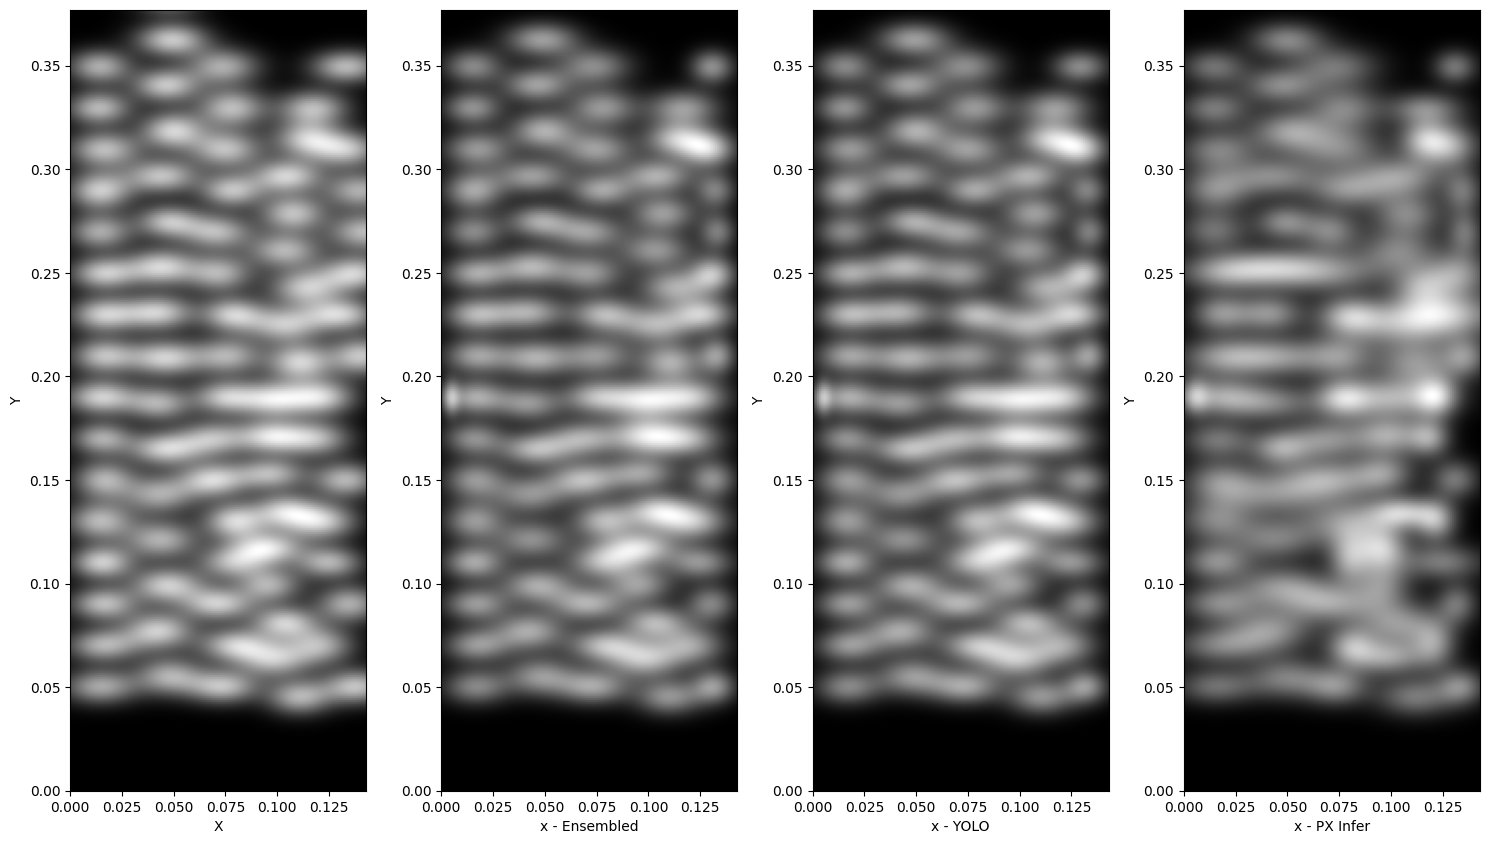

In [ ]:
plt.ion()
plt.tight_layout()
plt.show()